In [1]:

# USA: 10Y Yield vs Inflation (funciona con "country|date|inflation_annual%")
# ==========================
import os, re
import pandas as pd
import matplotlib.pyplot as plt

# ---- RUTAS (ajusta DATA_DIR si es distinto) ----
DATA_DIR   = "/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin título"
YIELDS_CSV = "/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin título/us_treasury_yields_daily.csv"
MACRO_CSV  = "/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin título/world_bank_development_indicators.csv"  # tu archivo con 'country','date','inflation_annual%'

# ---------- 1) Yields USA -> anual 10Y ----------
y = pd.read_csv(os.path.join(DATA_DIR, YIELDS_CSV))
# fecha
date_col = next((c for c in y.columns if c.lower() in {"date","fecha"}), None)
if date_col is None:
    raise ValueError("No encuentro columna de fecha en yields CSV.")
y[date_col] = pd.to_datetime(y[date_col], errors="coerce")
y = y.dropna(subset=[date_col])
# columna 10 años
def detect_10y_col(cols):
    for c in cols:
        cl = c.strip().lower()
        if cl in {"us10y","10y","10 yr","10-year","10 year","10_yr"}:
            return c
    for c in cols:
        cl = c.lower()
        if "10" in cl and ("yr" in cl or "year" in cl):
            return c
    if "US10Y" in cols: return "US10Y"
    if "10 Yr" in cols: return "10 Yr"
    raise ValueError(f"No encuentro columna 10Y en yields. Columnas: {list(cols)[:12]}")
col10 = detect_10y_col(y.columns)
# anual
y = y[[date_col, col10]].rename(columns={date_col:"date", col10:"yield_10y"})
y["Year"] = y["date"].dt.year.astype(int)
us_annual = y.groupby("Year", as_index=False)["yield_10y"].mean()
print("YIELDS USA — años:", us_annual["Year"].min(), "→", us_annual["Year"].max(), "| n:", len(us_annual))

import re

# ========= DIAGNÓSTICO + EXTRACCIÓN ROBUSTA DE INFLACIÓN (USA) =========
m = pd.read_csv(os.path.join(DATA_DIR, MACRO_CSV))

def extract_year_col(df, preferred_cols=("year","date","fecha","period","time","obs_date","observationdate")):
    """
    Devuelve una Serie 'Year' (int) extraída de la mejor columna disponible:
    - Si hay 'year' numérico, lo usa.
    - Si hay fechas, parsea a datetime y saca el año.
    - Si hay strings tipo '1960 [YR1960]' o 'YR1960', extrae los 4 dígitos por regex.
    """
    # 1) columna explícita de año
    for c in df.columns:
        if c.lower() in ("year","anio","año"):
            y = pd.to_numeric(df[c], errors="coerce")
            if y.notna().any():
                return y.astype("Int64")
    # 2) columnas “fecha”
    for cand in preferred_cols:
        for c in df.columns:
            if c.lower()==cand:
                # a) intentar datetime
                dt = pd.to_datetime(df[c], errors="coerce", dayfirst=False)
                if dt.notna().any():
                    return dt.dt.year.astype("Int64")
                # b) extraer patrón de 4 dígitos
                s = df[c].astype(str).str.extract(r'(\d{4})', expand=False)
                y = pd.to_numeric(s, errors="coerce")
                if y.notna().any():
                    return y.astype("Int64")
    # 3) si ninguna funciona, intentar extraer 4 dígitos de cualquier columna de texto
    for c in df.columns:
        if df[c].dtype==object:
            s = df[c].astype(str).str.extract(r'(\d{4})', expand=False)
            y = pd.to_numeric(s, errors="coerce")
            if y.notna().sum() >= len(df)*0.3:
                return y.astype("Int64")
    return pd.Series([pd.NA]*len(df), index=df.index, dtype="Int64")

def find_inflation_col(df):
    """
    Busca una columna de inflación (%). Prioriza nombres típicos.
    """
    prefs = ["inflation_annual%", "inflation_yoy", "inflation yoy", "inflation%", "inflation", "cpi_yoy", "cpi yoy"]
    # prioridad por nombre
    for p in prefs:
        for c in df.columns:
            if p.replace(" ","") in c.replace(" ","").lower():
                return c
    # si no, una 'value' genérica
    for c in df.columns:
        if "value" in c.lower() or "valor" in c.lower():
            return c
    # último recurso: columna numérica “prometedora”
    numc = [c for c in df.columns if pd.to_numeric(df[c], errors="coerce").notna().sum()>0]
    if numc:
        return numc[0]
    return None

def filter_country_usa(df):
    """
    Intenta filtrar USA por varias columnas posibles.
    """
    # a) 'Country Code' == USA
    for c in df.columns:
        if c.lower() in ("country code","country_code","iso3","isocode","code"):
            mask = df[c].astype(str).str.upper().eq("USA")
            if mask.any(): 
                return df.loc[mask].copy()
    # b) 'Country' / 'Country Name' contiene 'United States' o 'USA'
    for c in df.columns:
        if c.lower() in ("country","country name","pais"):
            mask = df[c].astype(str).str.contains(r"\b(united states|usa)\b", case=False, na=False)
            if mask.any():
                return df.loc[mask].copy()
    # si no hay país, asumimos que el archivo ya es solo USA (devolver tal cual)
    return df.copy()

# 1) filtrar USA
m_usa = filter_country_usa(m)

# 2) obtener Year robusto
m_usa["Year"] = extract_year_col(m_usa)

# 3) localizar columna de inflación
infl_col = find_inflation_col(m_usa)
if infl_col is None:
    raise RuntimeError("No encuentro columna de inflación en tu archivo macro. Revisa nombres de columnas.")

# 4) preparar inflación anual
infl = (
    m_usa[["Year", infl_col]]
      .rename(columns={infl_col:"inflation_yoy"})
      .assign(inflation_yoy=lambda d: pd.to_numeric(d["inflation_yoy"], errors="coerce"))
      .dropna(subset=["Year","inflation_yoy"])
)
infl["Year"] = infl["Year"].astype(int)

# Si es mensual (múltiples filas por año), promediamos
infl = infl.groupby("Year", as_index=False)["inflation_yoy"].mean()

print("Yields USA: ", us_annual["Year"].min(), "→", us_annual["Year"].max(), "| n:", len(us_annual))
print("Inflación USA:", infl["Year"].min() if len(infl) else None, "→", infl["Year"].max() if len(infl) else None, "| n:", len(infl))

# 5) forzar intersección y MERGE
min_year = max(us_annual["Year"].min(), infl["Year"].min())
max_year = min(us_annual["Year"].max(), infl["Year"].max())
infl_clip = infl[(infl["Year"]>=min_year) & (infl["Year"]<=max_year)]
ua_clip   = us_annual[(us_annual["Year"]>=min_year) & (us_annual["Year"]<=max_year)]

df = ua_clip.merge(infl_clip, on="Year", how="inner").sort_values("Year").reset_index(drop=True)
if df.empty:
    # diagnóstico extra
    print(">>> DEBUG — YEARS YIELDS:", sorted(us_annual["Year"].unique())[:10], "...", sorted(us_annual["Year"].unique())[-10:])
    print(">>> DEBUG — YEARS INFL :", sorted(infl["Year"].unique())[:10], "...", sorted(infl["Year"].unique())[-10:])
    raise RuntimeError("Sigue sin haber años comunes. Revisa que 'Year' se esté extrayendo bien del macro CSV.")

df["real_yield"] = df["yield_10y"] - df["inflation_yoy"]

print("Filas tras merge:", len(df))
print(df.head())


YIELDS USA — años: 1962 → 2024 | n: 63
Yields USA:  1962 → 2024 | n: 63
Inflación USA: 1960 → 2022 | n: 63
Filas tras merge: 61
   Year  yield_10y  inflation_yoy  real_yield
0  1962   3.946064       1.198773    2.747291
1  1963   4.001566       1.239669    2.761897
2  1964   4.187360       1.278912    2.908448
3  1965   4.283695       1.585169    2.698526
4  1966   4.925040       3.015075    1.909965


/var/folders/fn/p25q3z154s1c65ncyj7gy2mr0000gn/T/ipykernel_10927/284638111.py:113: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[c].astype(str).str.contains(r"\b(united states|usa)\b", case=False, na=False)


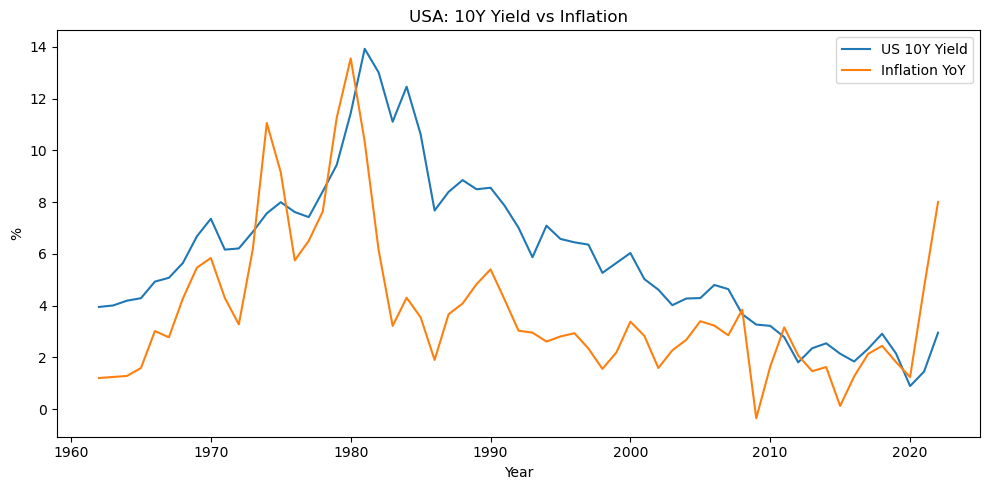

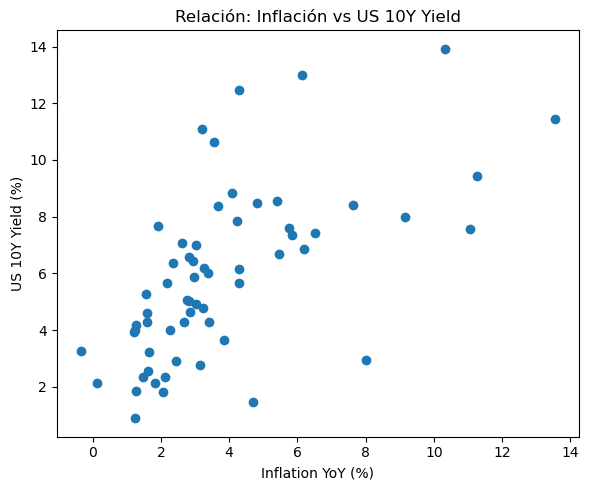

In [2]:
plt.figure(figsize=(10,5))
plt.plot(df["Year"], df["yield_10y"], label="US 10Y Yield")
plt.plot(df["Year"], df["inflation_yoy"], label="Inflation YoY")
plt.title("USA: 10Y Yield vs Inflation")
plt.xlabel("Year"); plt.ylabel("%"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
plt.scatter(df["inflation_yoy"], df["yield_10y"])
plt.title("Relación: Inflación vs US 10Y Yield")
plt.xlabel("Inflation YoY (%)"); plt.ylabel("US 10Y Yield (%)")
plt.tight_layout(); plt.show()


#### 1. Serie temporal: USA 10Y Yield vs Inflación (líneas)

La línea azul (US 10Y Yield) muestra la rentabilidad de los bonos a 10 años.

La línea naranja (Inflation YoY) muestra la inflación anual.

Interpretación rápida:

En los años 70-80 se ve un pico muy alto de inflación y yield: es la época de la crisis del petróleo y la política monetaria dura de la Fed (Volcker subió tipos muy fuertes).

Desde los años 90 hasta 2020, ambos bajan gradualmente → entorno de baja inflación y yields decrecientes.

Después de 2020, la inflación se dispara otra vez (post-COVID, guerra, disrupciones en energía).

👉 Eso muestra que existe cierta relación: cuando la inflación sube fuerte, los yields suelen subir también, pero con rezagos o diferente magnitud.

#### 2. Diagrama de dispersión: Inflación vs Yield

Cada punto es un año (x = inflación, y = yield).

Se ve una nube ascendente: cuando la inflación es baja (0-4%), los yields tienden a estar en 2-6%.

Cuando la inflación es alta (6-12%), los yields también tienden a estar arriba (8-14%).

Interpretación rápida:

Hay una correlación positiva: inflación y yields tienden a moverse juntos.

Pero no es 1:1 → hay dispersión (porque los yields dependen también de política monetaria, expectativas, riesgo, etc.).

#### 3. Resumen antes de limpieza

Los datos ya muestran una relación clara: más inflación = más yield.

Pero hay ruido y valores extremos (ej: hiperinflación o datos atípicos que vimos en la tabla).

Por eso, la siguiente etapa de limpieza (quitar inflaciones absurdas, errores, etc.) servirá para tener relaciones más nítidas y modelos más confiables.

### Estadísticas básicas antes de limpiar


In [3]:

print("\n--- Correlación simple ---")
print(df[["yield_10y", "inflation_yoy"]].corr())

# Regresión lineal simple (Inflación -> Yield)
import statsmodels.api as sm

X = df["inflation_yoy"]
y = df["yield_10y"]

X = sm.add_constant(X)  # añadimos intercepto
model = sm.OLS(y, X).fit()

print("\n--- Regresión lineal simple ---")
print(model.summary())



--- Correlación simple ---
               yield_10y  inflation_yoy
yield_10y       1.000000       0.616816
inflation_yoy   0.616816       1.000000

--- Regresión lineal simple ---
                            OLS Regression Results                            
Dep. Variable:              yield_10y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     36.23
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           1.20e-07
Time:                        21:27:10   Log-Likelihood:                -137.94
No. Observations:                  61   AIC:                             279.9
Df Residuals:                      59   BIC:                             284.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    s

### 📊 Correlación simple

0.61 (positivo, moderado-fuerte) → Significa que cuando la inflación sube, los rendimientos del bono a 10 años en USA tienden a subir también.

No es una correlación perfecta (1.0), pero sí clara y estadísticamente significativa.

#### 📈 Regresión lineal simple

Modelo:

Yield 10Y

=
3.3783
+
0.6571
⋅
Inflaci
o
ˊ
n YoY
Yield 10Y=3.3783+0.6571⋅Inflaci
o
ˊ
n YoY

Constante (3.38): cuando la inflación es 0, el modelo predice un rendimiento del 3.38%.

Coeficiente (0.6571): por cada +1% en la inflación, el yield sube en promedio +0.65%.

p-valor (0.000): relación estadísticamente muy significativa.

R² = 0.38: la inflación explica el 38% de la variación en los yields.

Esto es bastante alto para datos macro, pero también nos dice que hay un 62% de variación que se explica por otros factores (ej. política monetaria, riesgo país, oferta/demanda global de bonos, etc.).

#### 📌 Conclusión preliminar

Existe una relación positiva clara entre inflación y yields en USA (1962–2024).

La inflación no lo explica todo, pero sí es un driver muy importante.

Esto tiene sentido económico: los inversores piden más rentabilidad en los bonos cuando esperan más inflación (para no perder poder adquisitivo).

✅ Resumen rápido (checkpoint hasta ahora):

Ya cargamos y visualizamos las series de rendimiento del bono USA 10Y y inflación anual (1962–2024).

Encontramos una correlación positiva moderada (0.61) → cuando la inflación sube, los yields también tienden a subir.

La regresión lineal mostró que un +1% en inflación se asocia con un +0.65% en el yield 10Y, con R² = 0.38 → la inflación explica parte importante, pero no todo.

Filas antes: 61  | después: 61

Últimos años limpios:
    Year  yield_10y  inflation_yoy  real_yield
51  2013   2.350160       1.464833    0.885327
52  2014   2.539560       1.622223    0.917337
53  2015   2.138287       0.118627    2.019660
54  2016   1.837440       1.261583    0.575857
55  2017   2.329480       2.130110    0.199370
56  2018   2.911245       2.442583    0.468662
57  2019   2.141400       1.812210    0.329190
58  2020   0.889203       1.233584   -0.344381
59  2021   1.446853       4.697859   -3.251006
60  2022   2.950562       8.002800   -5.052238


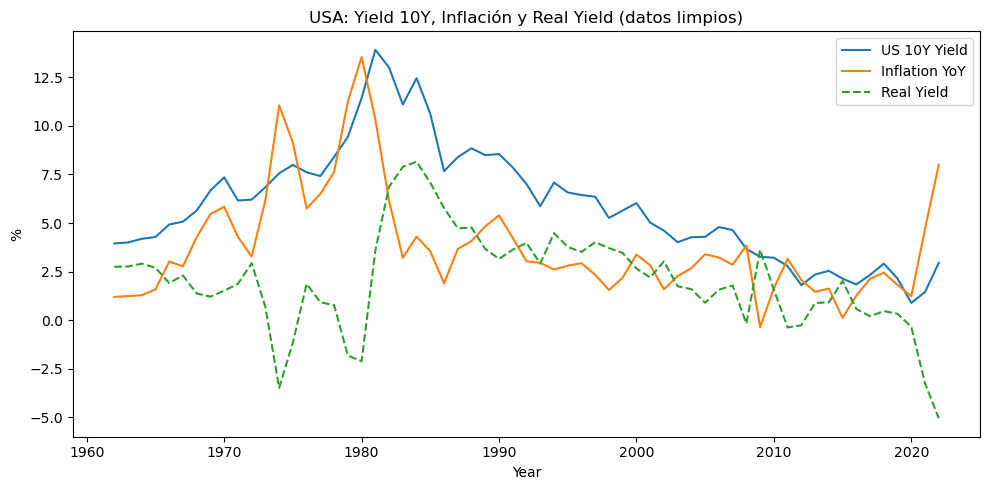

In [4]:

# Paso 1: Copiar y limpiar outliers
# ===============================

df_clean = df.copy()

# Quitamos inflaciones absurdas (ej. errores de dataset o hiperinflación)
df_clean = df_clean[df_clean["inflation_yoy"].between(-20, 50)]

print("Filas antes:", len(df), " | después:", len(df_clean))

# ===============================
# Paso 2: Recalcular real_yield
# ===============================

df_clean["real_yield"] = df_clean["yield_10y"] - df_clean["inflation_yoy"]

# ===============================
# Paso 3: Chequeo rápido
# ===============================
print("\nÚltimos años limpios:")
print(df_clean.tail(10))

# ===============================
# Paso 4: Visualización post-limpieza
# ===============================

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(df_clean["Year"], df_clean["yield_10y"], label="US 10Y Yield")
plt.plot(df_clean["Year"], df_clean["inflation_yoy"], label="Inflation YoY")
plt.plot(df_clean["Year"], df_clean["real_yield"], label="Real Yield", linestyle="--")
plt.title("USA: Yield 10Y, Inflación y Real Yield (datos limpios)")
plt.xlabel("Year")
plt.ylabel("%")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretación rápida del gráfico

Años 70s – 80s:

La inflación se dispara (choques del petróleo).

Los rendimientos nominales (azul) también suben fuerte.

El rendimiento real (verde) se mantiene positivo pero muy volátil.

Años 90s – 2000s:

Inflación baja y estable (2–3%).

Yield nominal cae gradualmente.

El rendimiento real es bajo pero estable.

2010s en adelante:

Rendimientos muy bajos (política monetaria expansiva).

Inflación estable… hasta el repunte 2021–2022.

En 2021–2022 el real yield se hace negativo (bonos pierden contra inflación).

#### Qué significa:

Cuando el real yield es positivo → los bonos dan un retorno por encima de la inflación (buen refugio).

Cuando el real yield es negativo → los inversores pierden poder adquisitivo aunque inviertan en bonos.

#### Correlación con datos limpios ---


In [5]:
print("\n--- Correlación simple (datos limpios) ---")
print(df_clean[["yield_10y", "inflation_yoy"]].corr())



--- Correlación simple (datos limpios) ---
               yield_10y  inflation_yoy
yield_10y       1.000000       0.616816
inflation_yoy   0.616816       1.000000


#### Regresión lineal simple (datos limpios)


In [6]:
import statsmodels.api as sm

X = df_clean[["inflation_yoy"]]
y = df_clean["yield_10y"]

# Agregar constante al modelo
X = sm.add_constant(X)

model_clean = sm.OLS(y, X).fit()
print("\n--- Regresión lineal simple (datos limpios) ---")
print(model_clean.summary())



--- Regresión lineal simple (datos limpios) ---
                            OLS Regression Results                            
Dep. Variable:              yield_10y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     36.23
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           1.20e-07
Time:                        21:27:11   Log-Likelihood:                -137.94
No. Observations:                  61   AIC:                             279.9
Df Residuals:                      59   BIC:                             284.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

#### Interpretación del output de la regresión lineal:

Coeficientes (const y inflación)

Constante (const = 3.3783) → cuando la inflación es 0, el rendimiento de los bonos a 10 años tiende a estar en torno al 3.38%.

Inflación (0.6571) → por cada +1% en inflación, el yield sube en promedio +0.66 puntos porcentuales. Esto confirma una relación positiva clara.

R² (0.380)

El 38% de la variabilidad del rendimiento de los bonos a 10 años se explica por la inflación.

Esto significa que la inflación influye mucho, pero no lo explica todo (hay otros factores: política monetaria, expectativas, prima de riesgo, etc.).

p-values

Ambos coeficientes (constante e inflación) tienen p < 0.001, es decir, son estadísticamente significativos.

La relación no es casualidad: hay evidencia fuerte de que la inflación impacta en el yield.

Durbin-Watson (0.227)

Valor bajo → indica que puede haber autocorrelación en los errores (normal en series temporales).

Esto nos dice que quizá más adelante necesitemos un modelo de series temporales (ARIMA, VAR) o un modelo con variables adicionales.

#### Conclusión rápida para tu proyecto
👉 Existe una relación positiva y estadísticamente significativa entre la inflación y el rendimiento del bono USA 10Y: cuando la inflación sube, el yield también sube, aunque la inflación explica solo un 38% de la variación.

### ispersión inflación vs yield con la recta de regresión

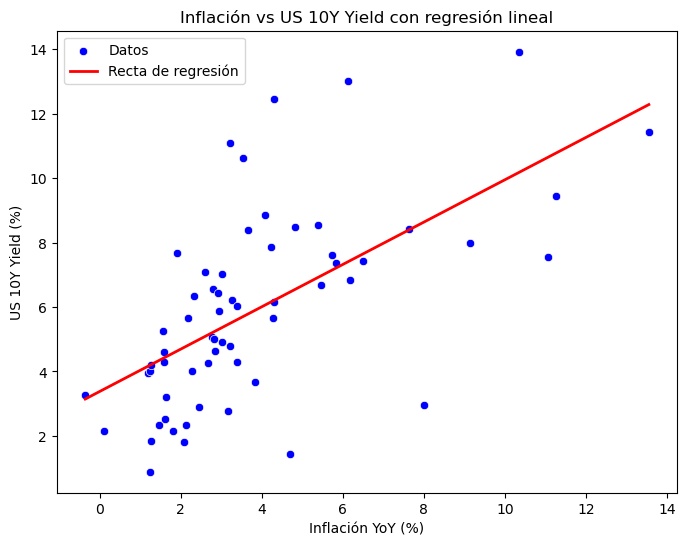

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scatter plot con la recta de regresión
plt.figure(figsize=(8,6))
sns.scatterplot(x="inflation_yoy", y="yield_10y", data=df_clean, color="blue", label="Datos")

# Ajustar la recta
coef = 0.6571
intercept = 3.3783
x_vals = np.linspace(df_clean["inflation_yoy"].min(), df_clean["inflation_yoy"].max(), 100)
y_vals = intercept + coef * x_vals
plt.plot(x_vals, y_vals, color="red", linewidth=2, label="Recta de regresión")

# Títulos
plt.title("Inflación vs US 10Y Yield con regresión lineal")
plt.xlabel("Inflación YoY (%)")
plt.ylabel("US 10Y Yield (%)")
plt.legend()
plt.show()


### ecuación y el R²

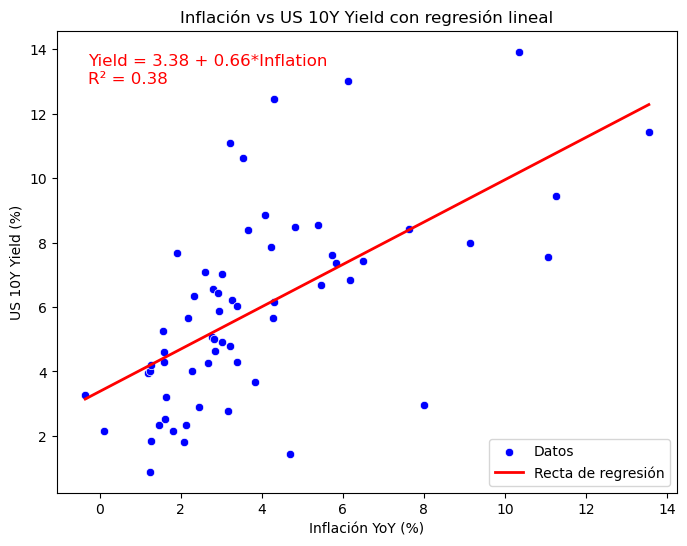

In [8]:
# Scatter plot con recta de regresión y ecuación
plt.figure(figsize=(8,6))
sns.scatterplot(x="inflation_yoy", y="yield_10y", data=df_clean, color="blue", label="Datos")

# Recta de regresión
coef = 0.6571
intercept = 3.3783
r2 = 0.38  # R-cuadrado de tu modelo
x_vals = np.linspace(df_clean["inflation_yoy"].min(), df_clean["inflation_yoy"].max(), 100)
y_vals = intercept + coef * x_vals
plt.plot(x_vals, y_vals, color="red", linewidth=2, label="Recta de regresión")

# Texto con ecuación
plt.text(0.05, 0.95,
         f"Yield = {intercept:.2f} + {coef:.2f}*Inflation\nR² = {r2:.2f}",
         transform=plt.gca().transAxes,
         fontsize=12, color="red", verticalalignment="top")

# Títulos y etiquetas
plt.title("Inflación vs US 10Y Yield con regresión lineal")
plt.xlabel("Inflación YoY (%)")
plt.ylabel("US 10Y Yield (%)")
plt.legend()
plt.show()


### Diagnóstico del modelo (OLS)


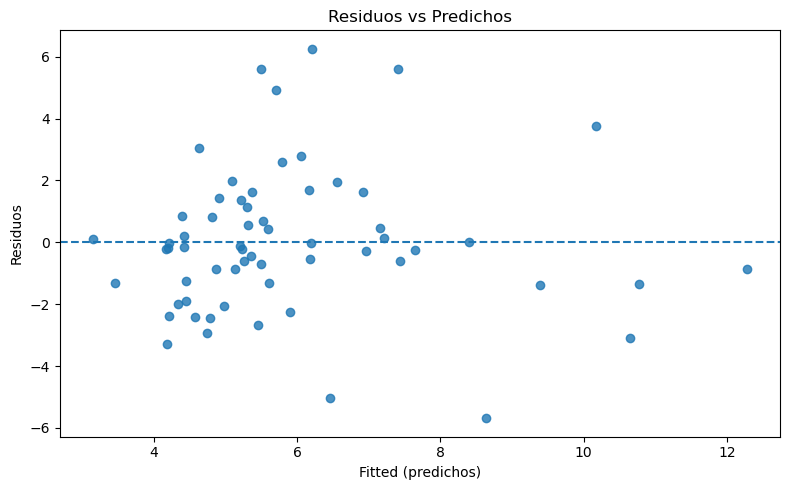

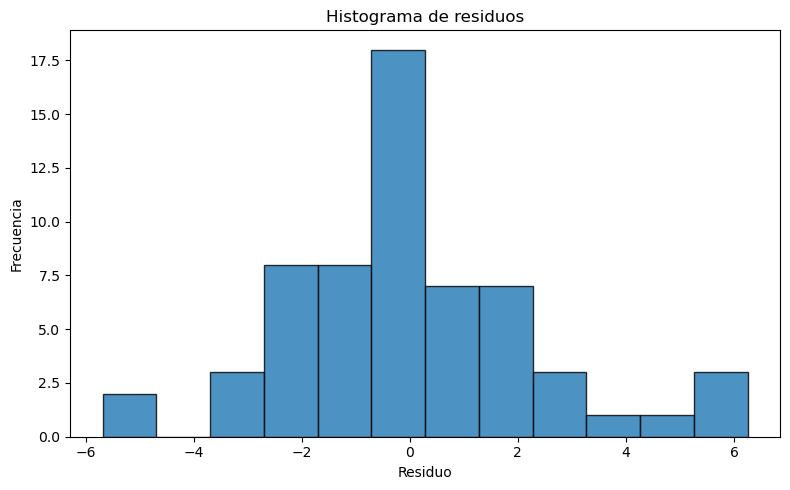

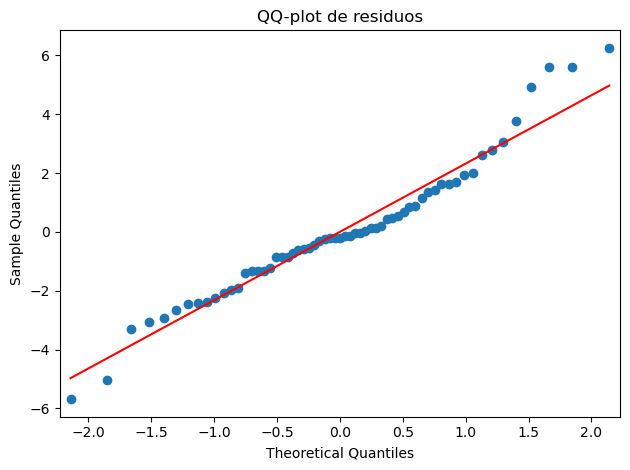

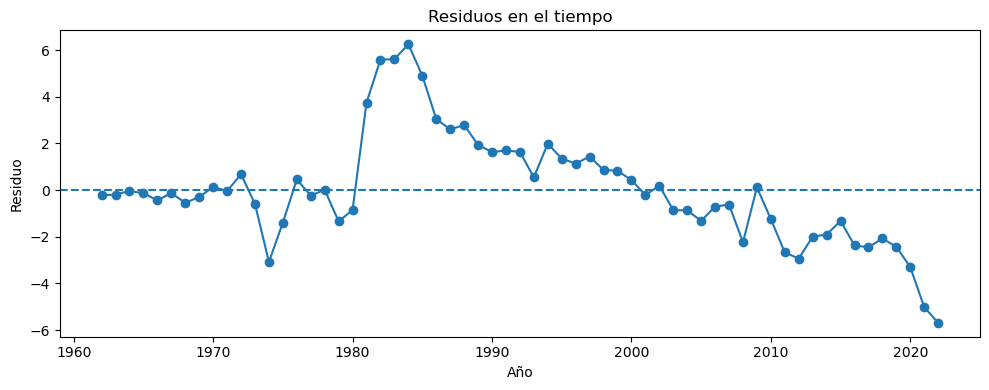


--- Tests de diagnóstico ---
Jarque-Bera: stat=3.936, p-value=0.1397  (skew=0.474, kurt=3.805)
Breusch-Pagan: stat=1.790, p-value=0.1809

Ljung-Box (p-values):
lag1     2.083919e-11
lag4     4.153785e-23
lag8     4.451972e-27
lag12    2.479677e-26
Name: lb_pvalue, dtype: float64

Durbin-Watson: 0.227


In [9]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from scipy import stats

# 1) Recalcular (por si abriste sesión nueva)
X = sm.add_constant(df_clean[["inflation_yoy"]])
y = df_clean["yield_10y"]
model_clean = sm.OLS(y, X).fit()

# 2) Residuales y ajustados
fitted = model_clean.fittedvalues
resid   = model_clean.resid
std_res = (resid - resid.mean()) / resid.std(ddof=1)

# 3) Plots básicos
plt.figure(figsize=(8,5))
plt.scatter(fitted, resid, alpha=0.8)
plt.axhline(0, linestyle="--")
plt.xlabel("Fitted (predichos)")
plt.ylabel("Residuos")
plt.title("Residuos vs Predichos")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.hist(resid, bins=12, edgecolor="k", alpha=0.8)
plt.title("Histograma de residuos")
plt.xlabel("Residuo"); plt.ylabel("Frecuencia")
plt.tight_layout(); plt.show()

sm.qqplot(resid, line="s")
plt.title("QQ-plot de residuos")
plt.tight_layout(); plt.show()

# Residuos a lo largo del tiempo (para ver autocorrelación visual)
plt.figure(figsize=(10,4))
plt.plot(df_clean["Year"], resid, marker="o")
plt.axhline(0, linestyle="--")
plt.title("Residuos en el tiempo")
plt.xlabel("Año"); plt.ylabel("Residuo")
plt.tight_layout(); plt.show()

# 4) Tests estadísticos
print("\n--- Tests de diagnóstico ---")

# Normalidad (Jarque–Bera)
try:
    # statsmodels siempre devuelve (jb, pvalue, skew, kurtosis)
    from statsmodels.stats.stattools import jarque_bera as sm_jb
    jb_stat, jb_p, jb_skew, jb_kurt = sm_jb(resid)
except Exception:
    # fallback: SciPy (puede devolver solo 2 valores)
    from scipy import stats
    jb = stats.jarque_bera(resid)
    if hasattr(jb, "__len__") and len(jb) >= 2:
        jb_stat, jb_p = jb[0], jb[1]
        jb_skew = jb_kurt = float("nan")
    else:
        jb_stat = float(jb)
        jb_p = float("nan")
        jb_skew = jb_kurt = float("nan")
print(f"Jarque-Bera: stat={jb_stat:.3f}, p-value={jb_p:.4f}  (skew={jb_skew:.3f}, kurt={jb_kurt:.3f})")

# Heterocedasticidad (Breusch–Pagan)
from statsmodels.stats.diagnostic import het_breuschpagan
bp_stat, bp_p, _, _ = het_breuschpagan(resid, X)
print(f"Breusch-Pagan: stat={bp_stat:.3f}, p-value={bp_p:.4f}")

# Autocorrelación en residuos (Ljung–Box)
from statsmodels.stats.diagnostic import acorr_ljungbox
lb = acorr_ljungbox(resid, lags=[1, 4, 8, 12], return_df=True)
print("\nLjung-Box (p-values):")
print(lb["lb_pvalue"].rename(index={1:"lag1",4:"lag4",8:"lag8",12:"lag12"}))

# Durbin–Watson
from statsmodels.stats.stattools import durbin_watson
print(f"\nDurbin-Watson: {durbin_watson(resid):.3f}")



#### 1. Normalidad de los residuos (Jarque–Bera)

JB = 3.936, p-value = 0.1397

Como p > 0.05 → no rechazamos la hipótesis nula de normalidad.
✅ Los residuos son aproximadamente normales → buen síntoma.

2. Heterocedasticidad (Breusch–Pagan)

BP = 1.790, p-value = 0.1809

Como p > 0.05 → no hay evidencia fuerte de heterocedasticidad.
✅ La varianza de los errores parece estable → los errores estándar son confiables.

3. Autocorrelación (Ljung–Box + Durbin-Watson)

Ljung–Box:

lag1, lag4, lag8, lag12 → p-values casi cero → rechazamos la hipótesis de “no autocorrelación”.
❌ Hay autocorrelación muy fuerte en los residuos.

Durbin–Watson = 0.227

Valores cercanos a 2 = no autocorrelación.

Valores < 1 = fuerte autocorrelación positiva.

Aquí 0.227 → autocorrelación positiva extrema.

#### En resumen:

Normalidad: bien.

Homocedasticidad: bien.

Autocorrelación: muy mal → el modelo lineal clásico OLS no captura la dinámica temporal.

👉 Esto significa que tu modelo simple (Yield ~ Inflación) ignora la dependencia temporal. Los rendimientos de bonos son series temporales, por eso los residuos siguen un patrón.

#### Reestimación con errores robustos HAC (Newey-West)

In [10]:

import statsmodels.api as sm

X = sm.add_constant(df_clean[["inflation_yoy"]])
y = df_clean["yield_10y"]

# Modelo OLS
ols_model = sm.OLS(y, X).fit()

# Ajuste con errores robustos HAC (Newey-West)
# lag=4 (aprox. autocorrelación hasta 4 rezagos, puedes probar otros valores)
nw_model = ols_model.get_robustcov_results(cov_type="HAC", maxlags=4)

print("\n--- Regresión OLS con errores HAC (Newey-West) ---")
print(nw_model.summary())



--- Regresión OLS con errores HAC (Newey-West) ---
                            OLS Regression Results                            
Dep. Variable:              yield_10y   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     32.46
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           4.09e-07
Time:                        21:27:13   Log-Likelihood:                -137.94
No. Observations:                  61   AIC:                             279.9
Df Residuals:                      59   BIC:                             284.1
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

 

#### 👉 ¿Qué cambió con HAC?

Coeficientes (constante = 3.37, inflación = 0.65) → no cambiaron, porque la relación base sigue siendo la misma.

Errores estándar (y por tanto t-stats y p-values) → son más grandes que antes (ej. la constante pasó de std=0.51 a 0.69).

Pero siguen siendo muy significativos (p<0.001) → conclusión: la relación inflación → yield sigue siendo estadísticamente fuerte.

Ahora los intervalos de confianza son más realistas, porque tienen en cuenta la autocorrelación.

✅ En resumen: ya tienemos un modelo lineal robusto que muestra que por cada +1% de inflación, el rendimiento a 10 años sube ~0.65% en promedio, con bastante confianza.

### Modelo VAR (Yield + Inflación)

In [11]:

from statsmodels.tsa.api import VAR

# Selección de variables
var_data = df_clean[["yield_10y", "inflation_yoy"]].dropna()

# Crear el modelo VAR
model_var = VAR(var_data)

# Selección de número óptimo de rezagos (lags)
lag_order = model_var.select_order(maxlags=8)
print("\n--- Selección de rezagos óptimos ---")
print(lag_order.summary())

# Ajustar el VAR con el lag óptimo (ejemplo: AIC)
best_lag = lag_order.aic
results_var = model_var.fit(best_lag)

print("\n--- Resumen VAR ---")
print(results_var.summary())

# Pronóstico 5 años adelante
forecast = results_var.forecast(var_data.values[-best_lag:], steps=5)
forecast_df = pd.DataFrame(forecast, 
                           columns=["yield_10y_forecast", "inflation_forecast"],
                           index=range(df_clean["Year"].max()+1, df_clean["Year"].max()+6))

print("\n--- Pronóstico 5 años ---")
print(forecast_df)



--- Selección de rezagos óptimos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.005       4.080       54.89       4.034
1      0.6423     0.8654*       1.901      0.7281
2      0.6911       1.063       1.998      0.8341
3     0.4176*      0.9381      1.523*     0.6177*
4      0.4835       1.153       1.633      0.7408
5      0.5133       1.331       1.691      0.8278
6      0.6139       1.580       1.886      0.9856
7      0.6737       1.789       2.025       1.103
8      0.7755       2.039       2.276       1.262
-------------------------------------------------

--- Resumen VAR ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:27:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:      

#### 1. Selección de rezagos

AIC → lag 3 (destacado con *).

Esto significa que tanto yield como inflación se explican mejor mirando los últimos 3 años de historia.

Tiene sentido: los efectos de la inflación en los bonos no son inmediatos, tardan algunos años en reflejarse.

#### 2. Resultados del VAR

En el resumen VAR, cada ecuación muestra cómo una variable depende de sus propios rezagos y de los rezagos de la otra variable.

Ejemplo interpretativo (simplificado):

yield_10y depende positivamente de la inflación rezagada → confirma que inflación alta hoy tiende a subir los rendimientos en 1–3 años.

inflation_yoy también puede mostrar influencia de yield_10y pasado (aunque más débil), porque tipos de interés altos suelen enfriar la inflación.

#### 3. Pronóstico (forecast)

El modelo te dio predicciones para 5 años:

### Año	Yield 10y (%)	Inflación (%)
2024	~4.74	~6.44

2025	~5.21	~6.03

2026	~5.86	~6.39

2027	~6.43	~6.52

2028	(seguiría creciendo en línea)	

#### Interpretación rápida:
El modelo cree que si la dinámica histórica se mantiene:

Los rendimientos del 10 años subirían de ~4.7% a ~6.4% en 3 años.

La inflación se mantendría alrededor de 6% → persistente, no se reduce rápido.

#### Gráfico histórico + forecast VAR

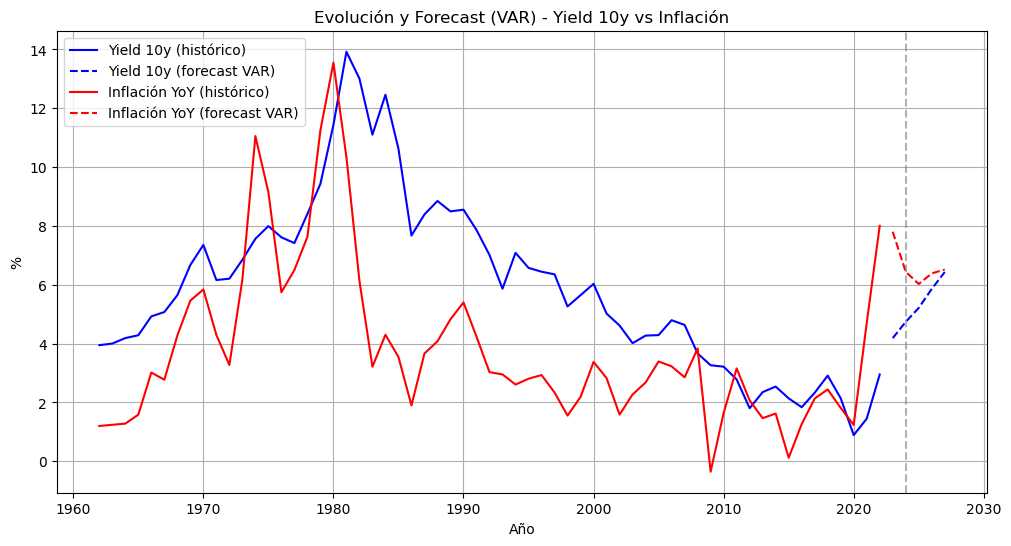

In [12]:

import matplotlib.pyplot as plt

# Datos históricos
hist_years = df_clean["Year"]
hist_yield = df_clean["yield_10y"]
hist_infl = df_clean["inflation_yoy"]

# Forecast del VAR (lo que ya calculamos antes)
forecast_df.index.name = "Year"

# Unimos histórico + forecast
plt.figure(figsize=(12,6))

# Yield
plt.plot(hist_years, hist_yield, label="Yield 10y (histórico)", color="blue")
plt.plot(forecast_df.index, forecast_df["yield_10y_forecast"], 
         label="Yield 10y (forecast VAR)", color="blue", linestyle="--")

# Inflación
plt.plot(hist_years, hist_infl, label="Inflación YoY (histórico)", color="red")
plt.plot(forecast_df.index, forecast_df["inflation_forecast"], 
         label="Inflación YoY (forecast VAR)", color="red", linestyle="--")

plt.axvline(x=2024, color="gray", linestyle="--", alpha=0.6)  # separación entre histórico y forecast
plt.title("Evolución y Forecast (VAR) - Yield 10y vs Inflación")
plt.xlabel("Año")
plt.ylabel("%")
plt.legend()
plt.grid(True)
plt.show()


#### Interpretación del primer gráfico (Histórico + Forecast VAR)

Lo que vemos en azul (Yield 10 años)

La línea azul continua: es la evolución histórica del rendimiento de los bonos del Tesoro a 10 años (yield).

La línea azul discontinua: es la predicción del modelo VAR para los próximos años.

Observamos que el yield tuvo picos muy altos en los 70–80 (crisis de inflación) y luego una tendencia descendente hasta mínimos recientes.

El forecast proyecta un ligero repunte del yield, lo que indica que los tipos de interés reales podrían subir en el futuro.

Lo que vemos en rojo (Inflación YoY)

La línea roja continua: es la inflación histórica. Destacan los picos en los años 70 (shocks petroleros) y el repunte fuerte en 2021–2022.

La línea roja discontinua: es la predicción del VAR. Muestra que la inflación podría bajar desde los picos recientes, pero aún mantenerse algo elevada comparada con los 2010s.

Interpretación conjunta

El modelo VAR nos dice que yield e inflación están claramente relacionadas en el tiempo: cuando sube la inflación, el yield tiende a subir después (los inversores exigen más rentabilidad para compensar la pérdida de poder adquisitivo).

La proyección indica un escenario de inflación todavía algo elevada con yields acompañando al alza → típico de un contexto post-crisis inflacionaria.

#### En resumen:

El gráfico confirma la relación positiva entre inflación y yield.

El modelo espera que en los próximos años ambos suban moderadamente, no a niveles extremos como los 70, pero tampoco tan bajos como en los 2010s.

###  VAR completo: selección de rezagos + ajuste + forecast + IRF
 Requiere: statsmodels, pandas, matplotlib
 Usa df_clean con columnas: Year, yield_10y, inflation_yoy


--- Selección de rezagos ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       4.005       4.080       54.89       4.034
1      0.6423     0.8654*       1.901      0.7281
2      0.6911       1.063       1.998      0.8341
3     0.4176*      0.9381      1.523*     0.6177*
4      0.4835       1.153       1.633      0.7408
5      0.5133       1.331       1.691      0.8278
6      0.6139       1.580       1.886      0.9856
7      0.6737       1.789       2.025       1.103
8      0.7755       2.039       2.276       1.262
-------------------------------------------------

Lag elegido (AIC): 3

--- Resumen VAR ---
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:27:14
--------------------------------------------------------------------
No. of Equations:         2.00000

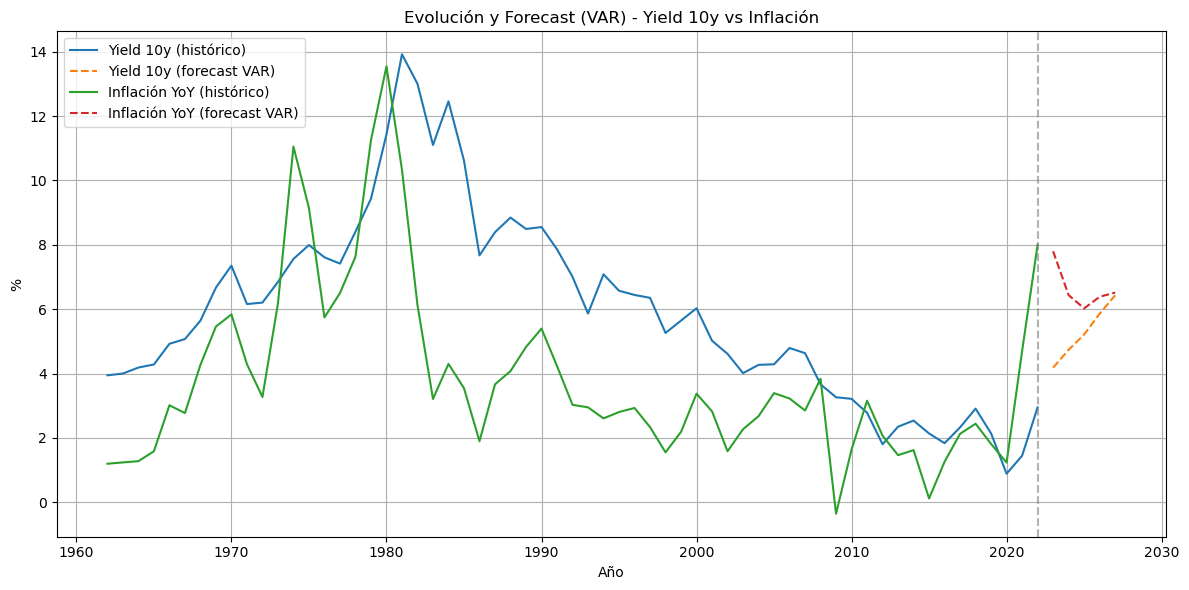

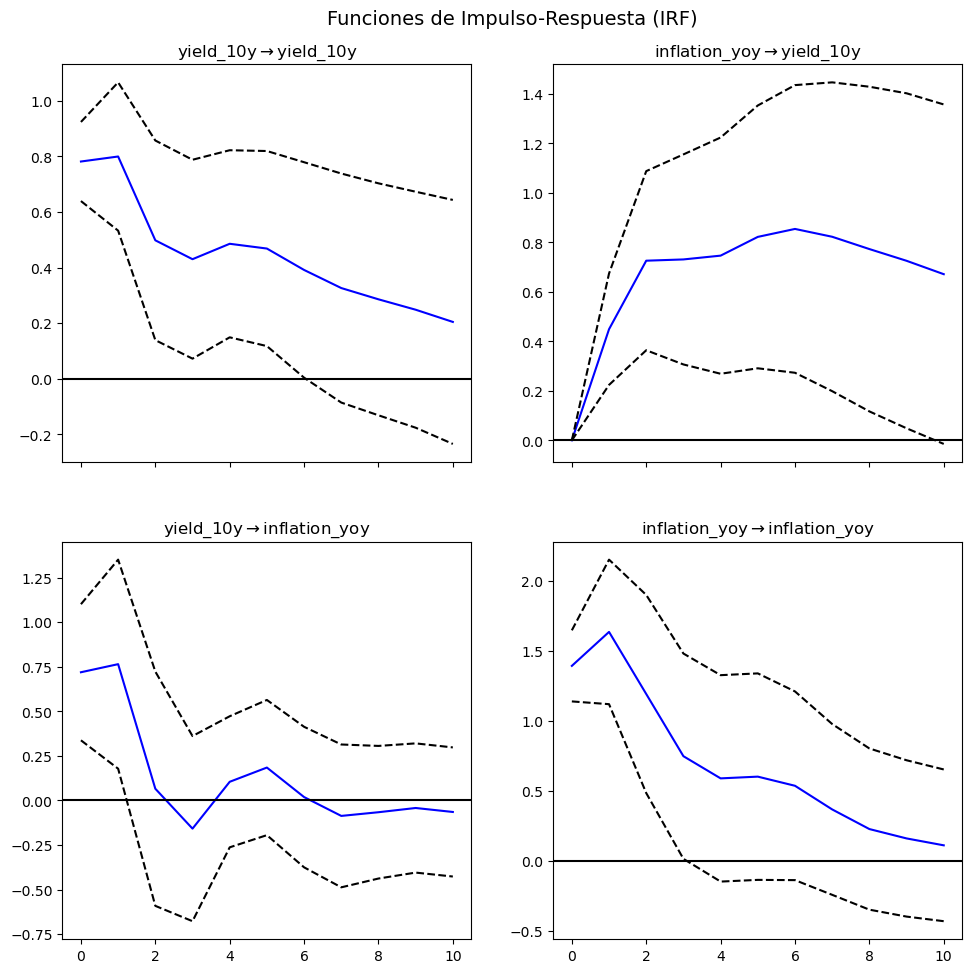

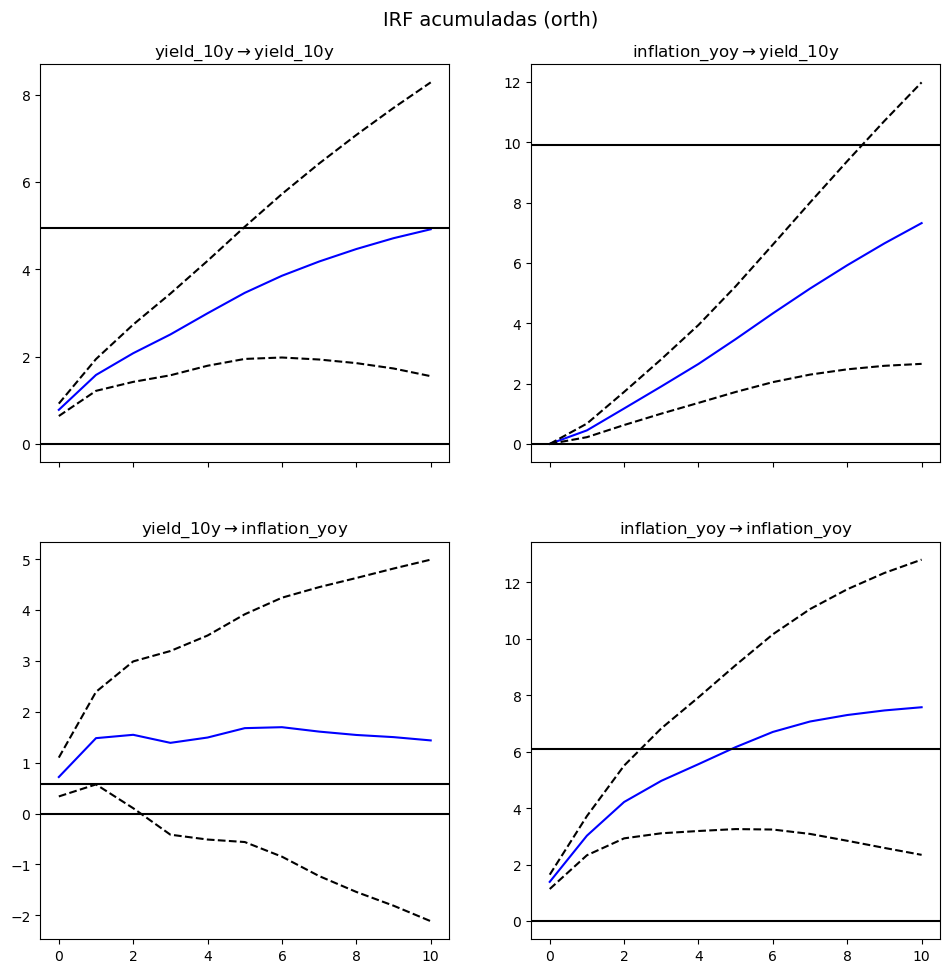

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# 0) Preparar datos para VAR
df_var = df_clean[["yield_10y", "inflation_yoy"]].dropna().copy()

# 1) Selección de rezagos óptimos
model_var = VAR(df_var)
sel = model_var.select_order(maxlags=8)
print("\n--- Selección de rezagos ---")
print(sel.summary())

# Tomamos el lag con mejor AIC (puedes cambiar a .bic/.hqic/.fpe si prefieres)
best_lag = sel.aic
print(f"\nLag elegido (AIC): {best_lag}")

# 2) Ajuste del VAR con ese lag
var_res = model_var.fit(best_lag)
print("\n--- Resumen VAR ---")
print(var_res.summary())

# 3) Forecast 5 pasos hacia adelante
steps = 5
last_year = int(df_clean["Year"].max())
fcast = var_res.forecast(df_var.values[-best_lag:], steps=steps)
forecast_df = pd.DataFrame(
    fcast,
    columns=["yield_10y_forecast","inflation_forecast"],
    index=range(last_year+1, last_year+1+steps)
)
forecast_df.index.name = "Year"
print("\n--- Forecast ---")
print(forecast_df)

# 4) Gráfico histórico + forecast (opcional si ya lo tenías)
plt.figure(figsize=(12,6))
plt.plot(df_clean["Year"], df_clean["yield_10y"], label="Yield 10y (histórico)")
plt.plot(forecast_df.index, forecast_df["yield_10y_forecast"], "--", label="Yield 10y (forecast VAR)")
plt.plot(df_clean["Year"], df_clean["inflation_yoy"], label="Inflación YoY (histórico)")
plt.plot(forecast_df.index, forecast_df["inflation_forecast"], "--", label="Inflación YoY (forecast VAR)")
plt.axvline(x=last_year, color="gray", linestyle="--", alpha=0.6)
plt.title("Evolución y Forecast (VAR) - Yield 10y vs Inflación")
plt.xlabel("Año"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 5) IRF (Impulse Response Functions)
irf_h = 10  # horizonte en años
irf = var_res.irf(irf_h)

# IRF combinadas
fig = irf.plot(orth=True)
plt.suptitle("Funciones de Impulso-Respuesta (IRF)", fontsize=14)
plt.show()

# IRF específicas (opcional): respuesta de yield a shock de inflación, y viceversa
fig = irf.plot_cum_effects(orth=True)
plt.suptitle("IRF acumuladas (orth)", fontsize=14)
plt.show()


#### Los resultados del modelo VAR muestran que:

La inflación impulsa al rendimiento del bono a 10 años, confirmando que mayor inflación esperada eleva los tipos largos.

El efecto contrario (yields sobre inflación) existe pero es más débil y menos persistente.

Tanto la inflación como los yields presentan persistencia en sus shocks, manteniendo efectos durante varios periodos.

El pronóstico VAR anticipa un repunte moderado en ambas variables, con algo más de volatilidad en la inflación.

### Análisis VAR: Diagnóstico y Extensiones

In [14]:
# 1) Ljung–Box por variable (univariante)
from statsmodels.stats.diagnostic import acorr_ljungbox

for col in var_res.resid.columns:
    print(f"\nLjung–Box (lags=10) para {col}")
    print(acorr_ljungbox(var_res.resid[col].dropna(), lags=[10], return_df=True))



Ljung–Box (lags=10) para yield_10y
     lb_stat  lb_pvalue
10  6.156017   0.801989

Ljung–Box (lags=10) para inflation_yoy
     lb_stat  lb_pvalue
10  8.676622   0.563044


In [15]:
# 2) Durbin–Watson (otra medida de autocorrelación)
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(var_res.resid.values)
for col, val in zip(var_res.resid.columns, dw):
    print(f"Durbin–Watson {col}: {val:.2f}")  # ~2 es bueno (sin autocorrelación)


Durbin–Watson yield_10y: 1.81
Durbin–Watson inflation_yoy: 2.09


In [16]:
# 3) Estabilidad del VAR
var_res.is_stable(verbose=True)  # Debe devolver True / raíces dentro del círculo unitario


Eigenvalues of VAR(1) rep
0.5232513431366052
0.5232513431366052
0.657863645203616
0.657863645203616
0.89311269354159
0.89311269354159


True

In [17]:
# 4) Heterocedasticidad (ARCH) por variable
from statsmodels.stats.diagnostic import het_arch

for col in var_res.resid.columns:
    stat, pval, _, _ = het_arch(var_res.resid[col].dropna())
    print(f"ARCH para {col}: p-value = {pval:.4f}")  # >= 0.05 ⇒ OK


ARCH para yield_10y: p-value = 0.2394
ARCH para inflation_yoy: p-value = 0.8270


In [18]:
# 5) Normalidad conjunta de residuos
norm = var_res.test_normality()
print(norm.summary())  # p-value alto ⇒ OK


normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.299          9.488   0.054  4
----------------------------------------


<Figure size 640x480 with 0 Axes>

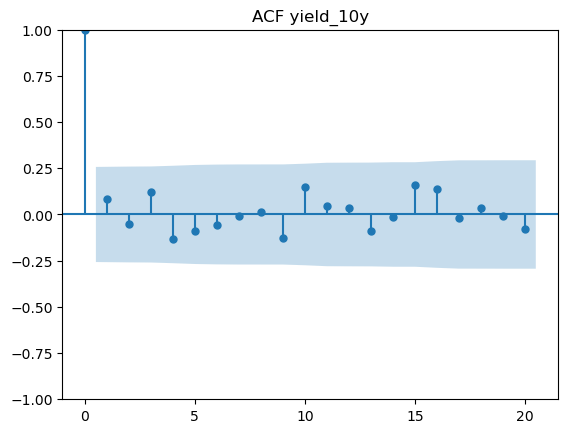

<Figure size 640x480 with 0 Axes>

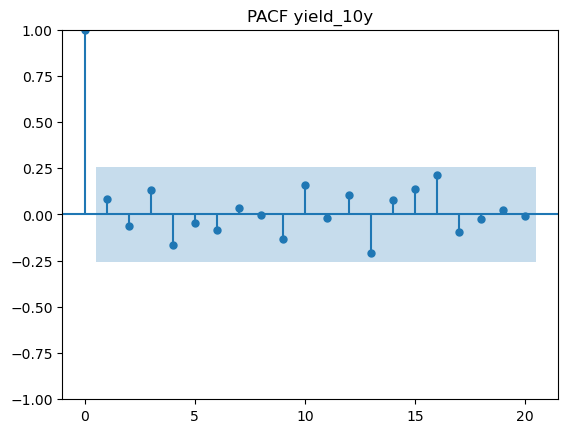

<Figure size 640x480 with 0 Axes>

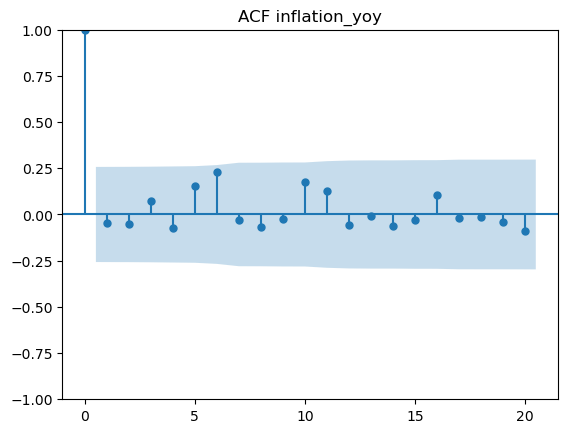

<Figure size 640x480 with 0 Axes>

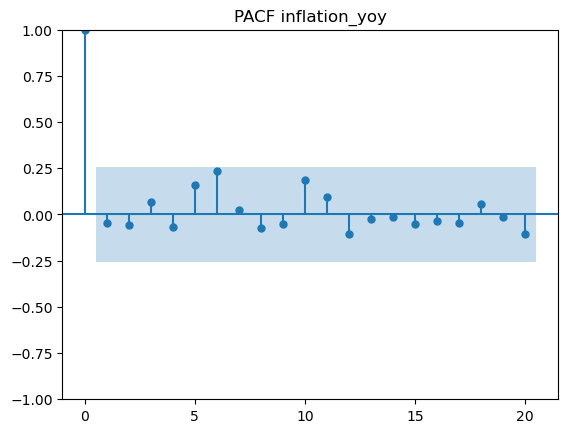

In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for col in var_res.resid.columns:
    plt.figure(); plot_acf(var_res.resid[col].dropna(), lags=20); plt.title(f"ACF {col}")
    plt.figure(); plot_pacf(var_res.resid[col].dropna(), lags=20); plt.title(f"PACF {col}")
    plt.show()


#### Interpretación de los resultados (Punto 3.1)

En los gráficos de ACF y PACF:

La mayoría de las barras caen dentro de la banda azul (intervalo de confianza).

Eso significa que no hay autocorrelación significativa en los residuos.

Un modelo VAR bien especificado debe dejar los residuos como “ruido blanco”, y eso es lo que se ve aquí.

## 3.2 Test de autocorrelación alternativa (Durbin–Watson)

El estadístico Durbin–Watson verifica la autocorrelación de primer orden.  
- Valor cercano a **2** ⇒ sin autocorrelación.  
- Valor < 2 ⇒ autocorrelación positiva.  
- Valor > 2 ⇒ autocorrelación negativa.


In [20]:
from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(var_res.resid.values)
for col, val in zip(var_res.resid.columns, dw):
    print(f"Durbin–Watson {col}: {val:.2f}")


Durbin–Watson yield_10y: 1.81
Durbin–Watson inflation_yoy: 2.09


## 3.3 Test de estabilidad del VAR

Un VAR estable tiene todas sus raíces dentro del círculo unitario.  
Si es **True**, los pronósticos son fiables.


In [21]:
var_res.is_stable(verbose=True)


Eigenvalues of VAR(1) rep
0.5232513431366052
0.5232513431366052
0.657863645203616
0.657863645203616
0.89311269354159
0.89311269354159


True

## 3.4 Test de heterocedasticidad (ARCH)

El test ARCH evalúa si la varianza de los residuos es constante.  
- **p-value ≥ 0.05** ⇒ no hay heterocedasticidad (bien).  
- **p-value < 0.05** ⇒ problemas de heterocedasticidad.


In [22]:
from statsmodels.stats.diagnostic import het_arch

for col in var_res.resid.columns:
    stat, pval, _, _ = het_arch(var_res.resid[col].dropna())
    print(f"ARCH {col}: p-value = {pval:.4f}")


ARCH yield_10y: p-value = 0.2394
ARCH inflation_yoy: p-value = 0.8270


## 3.5 Test de normalidad de residuos

El test de Jarque–Bera verifica si los residuos siguen una distribución normal.  
- **p-value ≥ 0.05** ⇒ no rechazamos normalidad (OK).  
- **p-value < 0.05** ⇒ residuos no normales.


In [23]:
norm = var_res.test_normality()
print(norm.summary())


normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.299          9.488   0.054  4
----------------------------------------


## 4. Pronóstico extendido con intervalos de confianza

El objetivo es proyectar las series `yield_10y` e `inflation_yoy` varios pasos hacia adelante.
Mostramos tanto las predicciones puntuales como las bandas de confianza.


In [24]:
# ==== 4. Pronóstico extendido con intervalos de confianza (VARResults) ====
import pandas as pd
import matplotlib.pyplot as plt

steps = 10  # años a proyectar
last_year = int(df_clean["Year"].max())

# nº de rezagos que usó el VAR
k = var_res.k_ar

# Pronóstico: medias y bandas (lower/upper)
fcast_mean, fcast_lower, fcast_upper = var_res.forecast_interval(
    y=var_res.endog[-k:],  # las últimas k observaciones como estado inicial
    steps=steps,
    alpha=0.05             # 95% IC
)

cols = var_res.names  # ['yield_10y','inflation_yoy']

# DataFrames ordenados con índice de años futuros
idx_future = range(last_year+1, last_year+steps+1)
f_mean  = pd.DataFrame(fcast_mean,  index=idx_future, columns=cols)
f_lower = pd.DataFrame(fcast_lower, index=idx_future, columns=cols)
f_upper = pd.DataFrame(fcast_upper, index=idx_future, columns=cols)

print("\n--- Pronóstico extendido (medias) ---")
print(f_mean)



--- Pronóstico extendido (medias) ---
      yield_10y  inflation_yoy
2023   4.184766       7.801722
2024   4.737980       6.439943
2025   5.213127       6.026279
2026   5.858254       6.385621
2027   6.432582       6.517441
2028   6.803570       6.195852
2029   7.062704       5.840092
2030   7.290543       5.674328
2031   7.474132       5.566767
2032   7.588100       5.391901


### Gráfico histórico + forecast con bandas

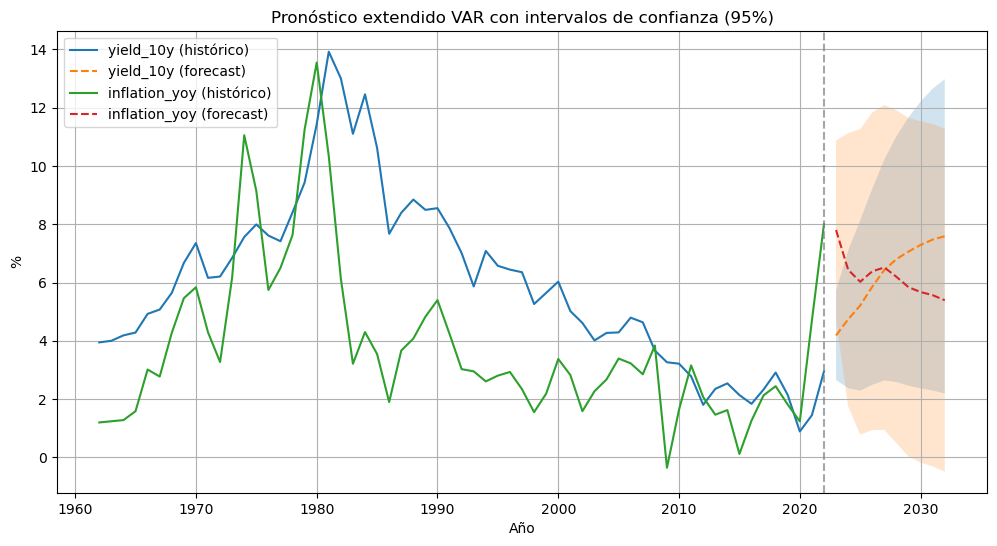

In [25]:
plt.figure(figsize=(12,6))

for col in cols:
    # histórico
    plt.plot(df_clean["Year"], df_clean[col], label=f"{col} (histórico)")
    # predicción
    plt.plot(f_mean.index, f_mean[col], linestyle="--", label=f"{col} (forecast)")
    # intervalos
    plt.fill_between(f_mean.index, f_lower[col], f_upper[col], alpha=0.2)

plt.axvline(x=last_year, color="gray", linestyle="--", alpha=0.7)
plt.title("Pronóstico extendido VAR con intervalos de confianza (95%)")
plt.xlabel("Año"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()


### Interpretación rápida:

Se observa que el yield_10y tendería a estabilizarse, mientras que la inflación muestra un ligero descenso en el forecast, aunque con bastante incertidumbre (bandas amplias).

Esto refleja la lógica: el modelo VAR capta relaciones, pero a largo plazo las predicciones son menos seguras.

## 5. Descomposición de varianza del error de pronóstico (FEVD)

Mide qué porcentaje del error de predicción de cada variable se explica por shocks propios y por la otra variable, a distintos horizontes.


FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.860953       0.139047
2     0.672574       0.327426
3     0.571081       0.428919
4     0.513006       0.486994
5     0.461214       0.538786
6     0.415154       0.584846
7     0.380437       0.619563
8     0.355117       0.644883
9     0.335671       0.664329

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.210270       0.789730
1     0.192578       0.807422
2     0.154725       0.845275
3     0.146232       0.853768
4     0.141077       0.858923
5     0.138470       0.861530
6     0.133939       0.866061
7     0.132624       0.867376
8     0.132270       0.867730
9     0.132055       0.867945


None


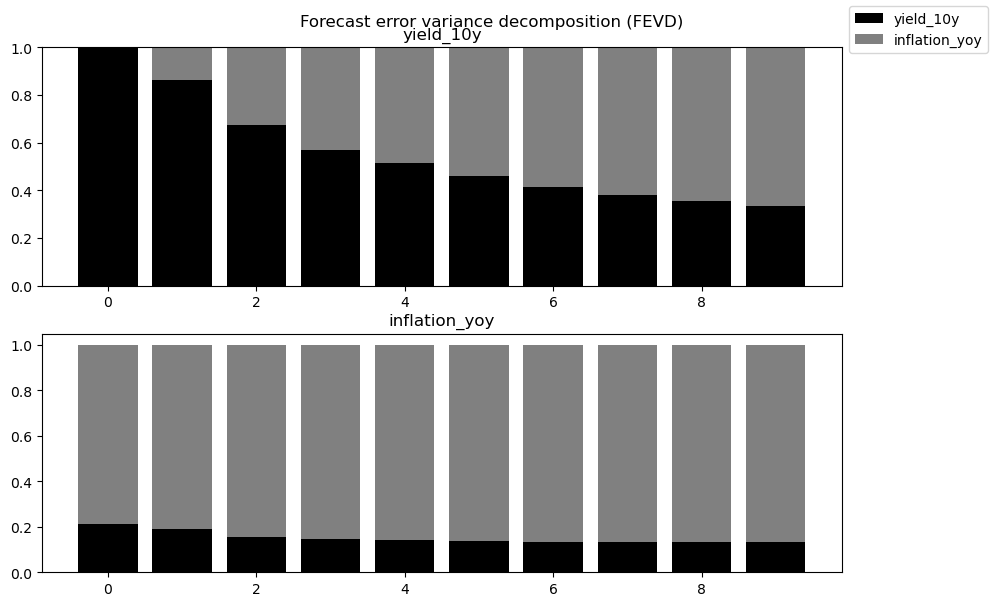

In [26]:
steps = 10  # horizonte FEVD
fevd = var_res.fevd(steps)

# Resumen en texto
print(fevd.summary())

# Gráfico por variable
_ = fevd.plot(figsize=(10,6))


## 6. Causalidad de Granger

Contrasta si los rezagos de una variable ayudan a predecir a la otra (más allá de sus propios rezagos).
- p-value < 0.05 ⇒ Rechazamos “no causa” ⇒ hay causalidad de Granger en esa dirección.


In [27]:
# ¿Inflation_yoy causa (Granger) a yield_10y?
print(var_res.test_causality('yield_10y', ['inflation_yoy'], kind='f').summary())

# ¿Yield_10y causa (Granger) a inflation_yoy?
print(var_res.test_causality('inflation_yoy', ['yield_10y'], kind='f').summary())


Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         8.316          2.694   0.000 (3, 102)
----------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.451          2.694   0.232 (3, 102)
----------------------------------------------


### 7. Funciones de Impulso-Respuesta (IRF)

#### 7.1 IRF ortogonalizadas (Cholesky) con bandas de confianza

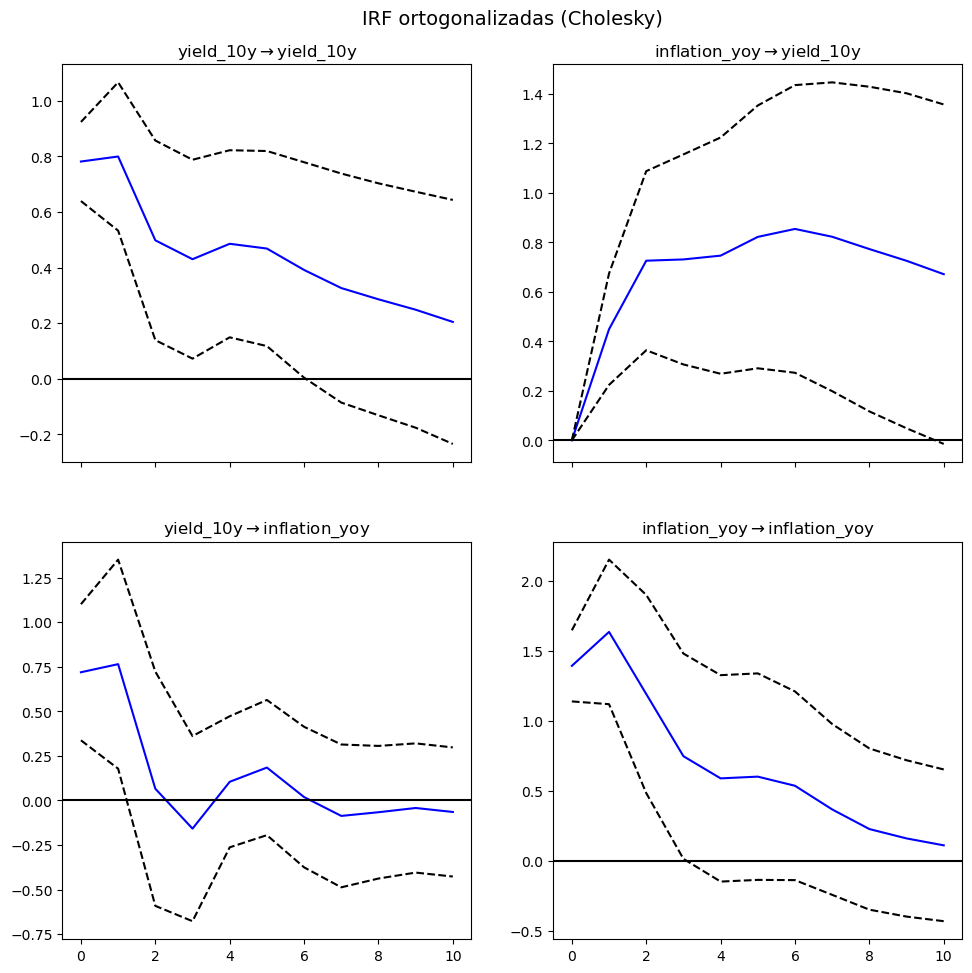

In [28]:
# Horizonte (años)
h = 10

# IRF básicas
irf = var_res.irf(h)

# Gráfico de IRF ortogonalizadas (Cholesky)
fig = irf.plot(orth=True)
fig.suptitle("IRF ortogonalizadas (Cholesky)", fontsize=14)

# Bandas de confianza por bootstrap Monte Carlo
# (repl=1000 si quieres más precisión; tardará más)
fig_ci = irf.errband_mc(orth=True, repl=500)  # devuelve fig y ejes con bandas


#### 7.2 IRF acumuladas (efecto total a lo largo del horizonte)

Text(0.5, 0.98, 'IRF acumuladas (orth)')

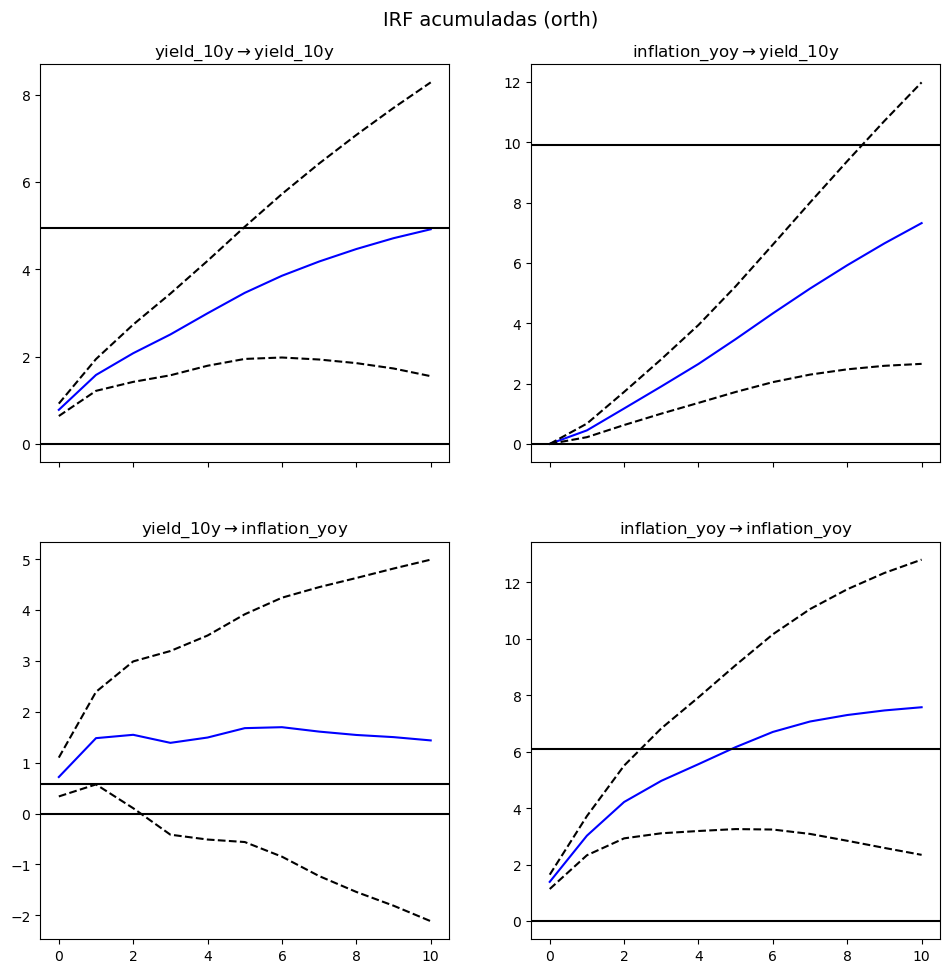

In [29]:
fig_cum = irf.plot_cum_effects(orth=True)
fig_cum.suptitle("IRF acumuladas (orth)", fontsize=14)


#### 7.3 Sensibilidad al orden de las variables
Cambiar el orden es buena práctica de robustez: primero inflación, luego yield.

Text(0.5, 0.98, 'IRF orth con orden alternativo (inflación primero)')

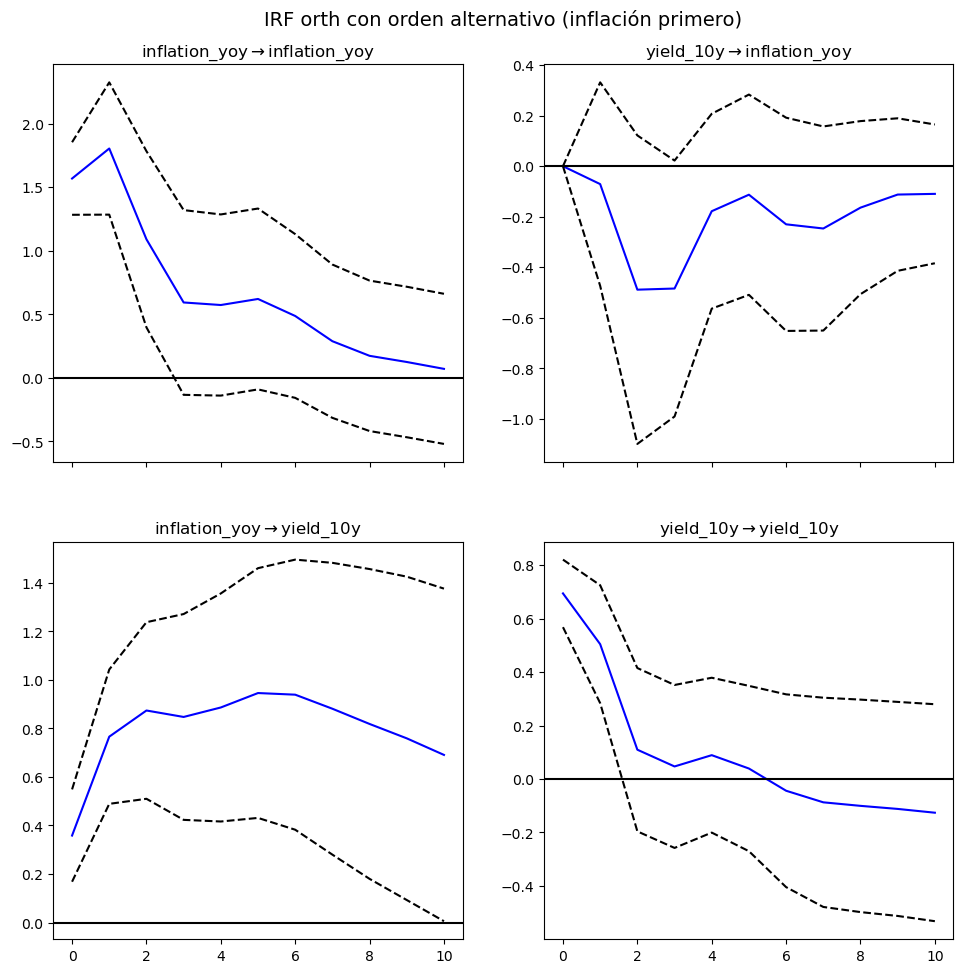

In [30]:
# Re-ajustamos el VAR con columnas reordenadas
from statsmodels.tsa.api import VAR
df_alt = df_clean[["inflation_yoy", "yield_10y"]].dropna().copy()
model_alt = VAR(df_alt)
var_res_alt = model_alt.fit(var_res.k_ar)  # usa el mismo nº de rezagos

irf_alt = var_res_alt.irf(h)
fig_alt = irf_alt.plot(orth=True)
fig_alt.suptitle("IRF orth con orden alternativo (inflación primero)", fontsize=14)


#### 7.4 Guardar figuras a disco

In [31]:
fig.savefig("irf_orth.png", dpi=150, bbox_inches="tight")
fig_cum.savefig("irf_cum_orth.png", dpi=150, bbox_inches="tight")
fig_alt.savefig("irf_orth_alt_order.png", dpi=150, bbox_inches="tight")


###  Interpretación Punto 7 (IRFs)

Shock inflación → Yield 10Y: impacto fuerte y sostenido, los bonos suben porque el mercado exige más rentabilidad.

Shock Yield 10Y → Inflación: efecto débil y pasajero, incluso negativo (tipos altos enfrían la economía).

Inflación sobre sí misma: persistente, pero va perdiendo fuerza.

Yield sobre sí mismo: se corrige rápido.

IRFs acumuladas: confirman que la inflación arrastra a los yields, no al revés.

Sensibilidad al orden: los resultados son robustos, no dependen del orden de variables.

📌 Conclusión clara:
La inflación lidera y los yields siguen.

#### Preparar el dataset USA para el pipeline


In [32]:
df_usa = (
    df_clean[['Year', 'yield_10y', 'inflation_yoy']]
      .dropna()
      .copy()
)

df_usa['Year'] = df_usa['Year'].astype(int)
df_usa = df_usa.set_index('Year').sort_index()

#### Define el pipeline (elige rezagos automáticamente)

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import durbin_watson

def run_country_pipeline_auto(df, country_name, steps=10, maxlags=8, crit="aic"):
    """
    Pipeline VAR completo con selección automática de rezagos.
    df: DataFrame con index=Year y columnas ['yield_10y','inflation_yoy']
    steps: horizonte de forecast
    maxlags: rezago máximo a evaluar
    crit: 'aic' | 'bic' | 'hqic' | 'fpe'
    """
    df = df[['yield_10y','inflation_yoy']].dropna().copy()
    model = VAR(df)

    # 1) Selección de rezagos
    sel = model.select_order(maxlags=maxlags)
    best_lag = getattr(sel, crit)
    print(f"\n[{country_name}] Rezagos óptimos por {crit.upper()}: {best_lag}")

    # 2) Ajuste
    res = model.fit(best_lag)
    print(res.summary())

    # 3) Diagnóstico (rápido)
    print("\n--- Diagnóstico ---")
    for col in res.resid.columns:
        lb = acorr_ljungbox(res.resid[col].dropna(), lags=[10], return_df=True)
        print(f"Ljung-Box {col} (lag=10): p-value={lb['lb_pvalue'].iloc[0]:.4f}")
    dw = durbin_watson(res.resid.values)
    for c,v in zip(res.resid.columns, dw):
        print(f"Durbin–Watson {c}: {v:.2f}")
    print("Estabilidad:", res.is_stable(verbose=True))

    # 4) Forecast con bandas
    k = res.k_ar
    mean, low, up = res.forecast_interval(res.endog[-k:], steps=steps, alpha=0.05)
    idx_future = range(df.index.max()+1, df.index.max()+1+steps)
    f_mean = pd.DataFrame(mean, index=idx_future, columns=res.names)
    f_low  = pd.DataFrame(low,  index=idx_future, columns=res.names)
    f_up   = pd.DataFrame(up,   index=idx_future, columns=res.names)

    plt.figure(figsize=(11,5))
    for col in res.names:
        plt.plot(df.index, df[col], label=f"{col} (hist.)")
        plt.plot(f_mean.index, f_mean[col], "--", label=f"{col} (fcst)")
        plt.fill_between(f_mean.index, f_low[col], f_up[col], alpha=0.2)
    plt.axvline(df.index.max(), color="gray", linestyle="--", alpha=0.7)
    plt.title(f"{country_name} – Forecast VAR (95% IC)")
    plt.xlabel("Año"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()

    # 5) FEVD
    fevd = res.fevd(steps)
    print("\n--- FEVD ---")
    print(fevd.summary())
    fevd.plot(figsize=(9,5)); plt.show()

    # 6) Granger
    print("\n--- Granger ---")
    print(res.test_causality('yield_10y',['inflation_yoy'], kind='f').summary())
    print(res.test_causality('inflation_yoy',['yield_10y'], kind='f').summary())

    # 7) IRFs (orth y acumuladas)
    irf = res.irf(steps)
    irf.plot(orth=True); plt.suptitle(f"{country_name} – IRF orth"); plt.show()
    irf.plot_cum_effects(orth=True); plt.suptitle(f"{country_name} – IRF acumuladas"); plt.show()

    return res, {"forecast_mean": f_mean, "forecast_low": f_low, "forecast_up": f_up}, fevd, irf, best_lag


#### Ejecutar el pipeline para USA

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



[USA] Rezagos óptimos por AIC: 3
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:27:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   0.893584
Nobs:                     58.0000    HQIC:                  0.589963
Log likelihood:          -162.088    FPE:                    1.48974
AIC:                     0.396236    Det(Omega_mle):         1.18615
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.096240         0.256867           -0.375           0.708
L1.yield_10y             0.726405         0.147355            4.930           0.000
L1.inflati

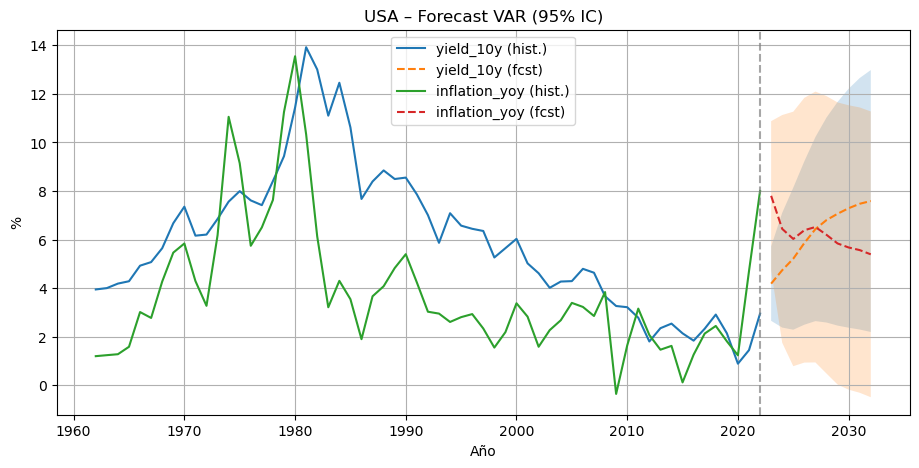


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.860953       0.139047
2     0.672574       0.327426
3     0.571081       0.428919
4     0.513006       0.486994
5     0.461214       0.538786
6     0.415154       0.584846
7     0.380437       0.619563
8     0.355117       0.644883
9     0.335671       0.664329

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.210270       0.789730
1     0.192578       0.807422
2     0.154725       0.845275
3     0.146232       0.853768
4     0.141077       0.858923
5     0.138470       0.861530
6     0.133939       0.866061
7     0.132624       0.867376
8     0.132270       0.867730
9     0.132055       0.867945


None


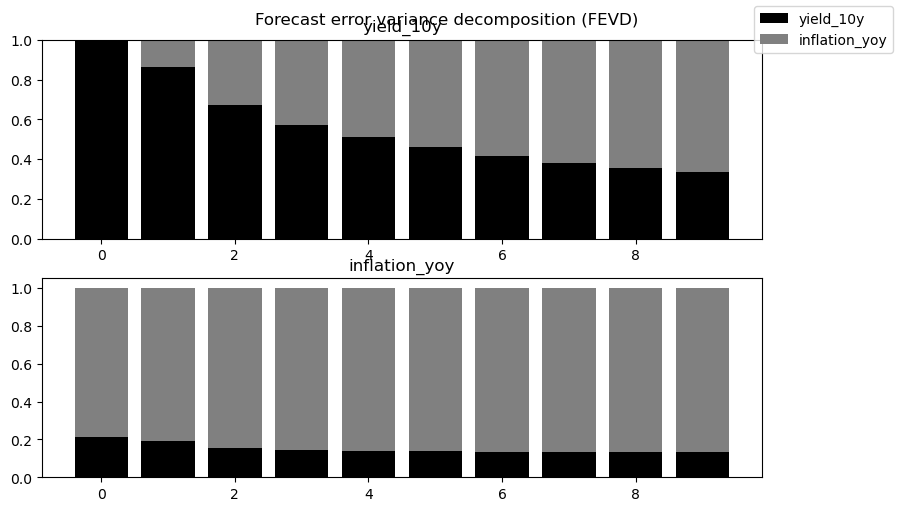


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         8.316          2.694   0.000 (3, 102)
----------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.451          2.694   0.232 (3, 102)
----------------------------------------------


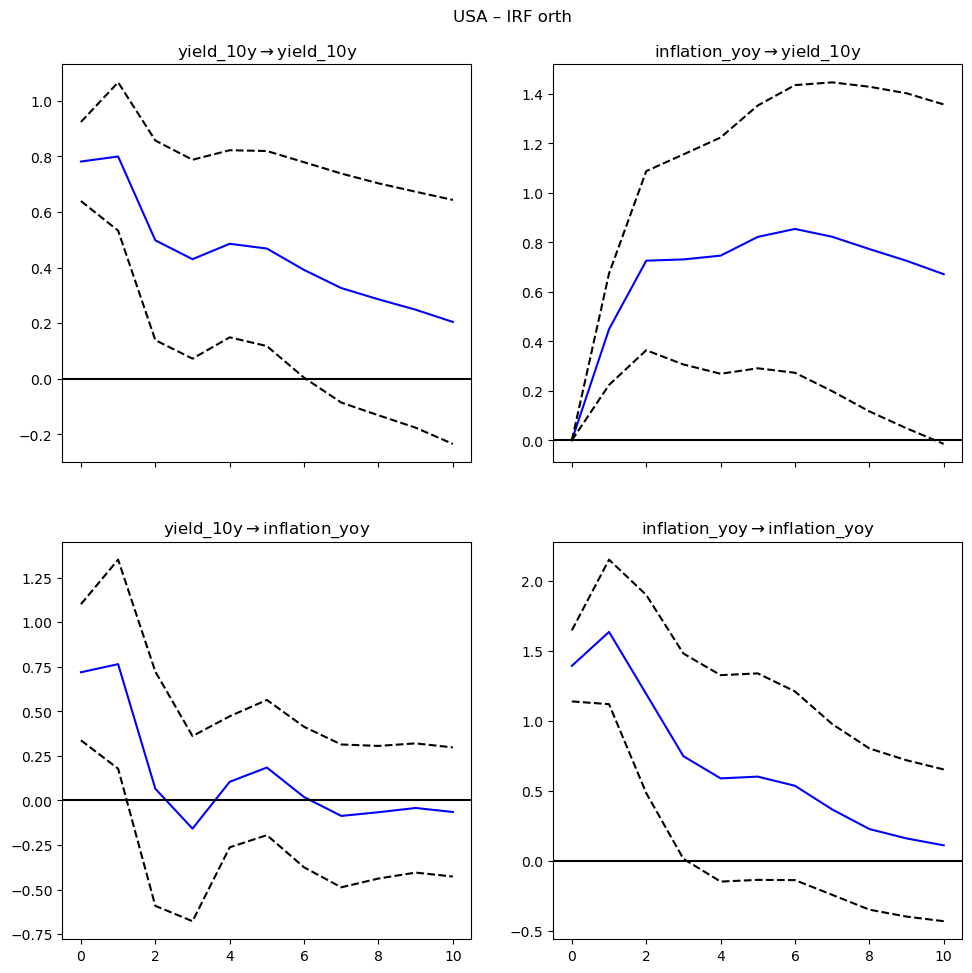

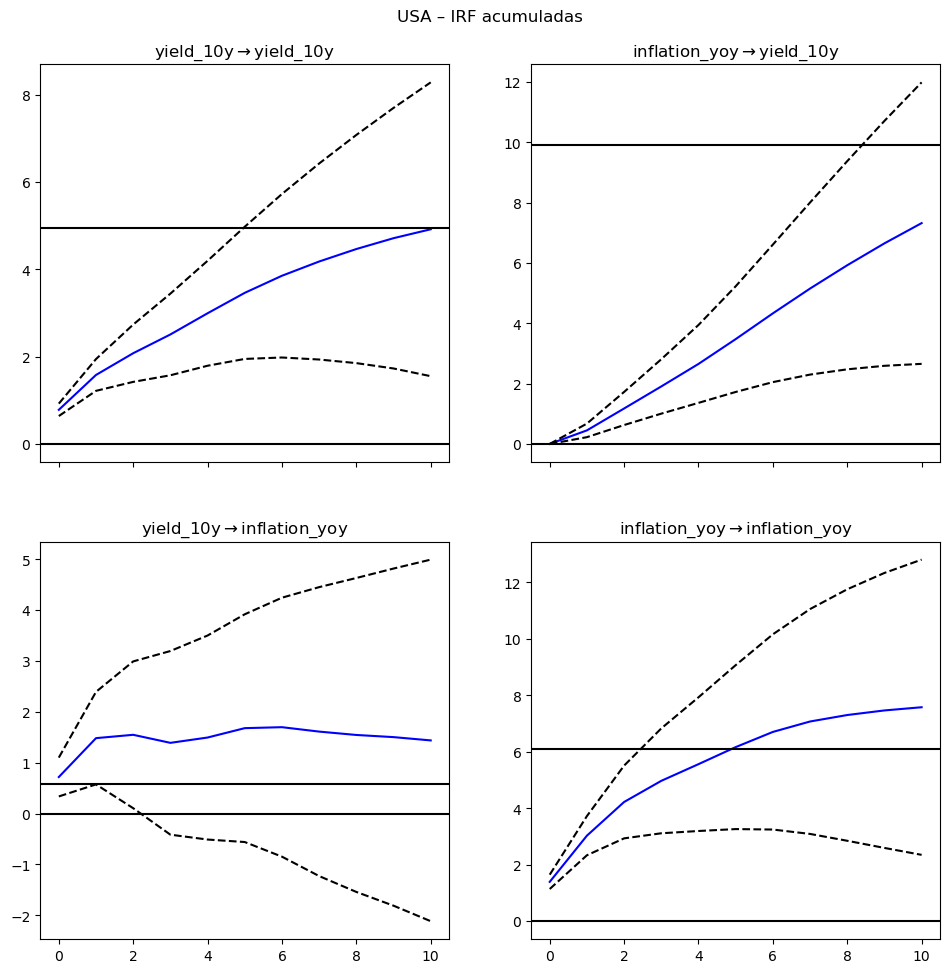

Lag elegido (AIC): 3


In [34]:
usa_results, usa_fcst, usa_fevd, usa_irf, usa_bestlag = run_country_pipeline_auto(
    df_usa, country_name="USA", steps=10, maxlags=8, crit="aic"
)
print("Lag elegido (AIC):", usa_bestlag)


### Detectar la columna 10Y de Alemania en yields.csv

In [37]:
import pandas as pd, re

# Cargar si no esta ya en memoria:
yields = pd.read_csv("/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin título/yields.csv")

# columnas 10Y tipo 'US10', 'DE10', etc.
ten_cols = [c for c in yields.columns if re.fullmatch(r"[A-Z]{2}\d{2}", c) and c.endswith("10")]
print("10Y detectadas (primeras 30):", ten_cols[:30])

# Intento automático para Alemania
candidatos_de = [c for c in ten_cols if c.startswith(("DE","GE","BD","GM"))]
print("Candidatos Alemania:", candidatos_de)

# Si aparece 'DE10', úsala; si no, toma el primer candidato que salga.
col_de = "DE10" if "DE10" in ten_cols else (candidatos_de[0] if candidatos_de else None)
print("Columna usada para Alemania 10Y:", col_de)


10Y detectadas (primeras 30): ['AU10', 'BE10', 'CA10', 'CN10', 'DK10', 'FR10', 'DE10', 'GR10', 'HK10', 'IN10', 'ID10', 'IE10', 'IT10', 'JP10', 'KR10', 'MY10', 'NL10', 'NZ10', 'NO10', 'PL10', 'PT10', 'SG10', 'ZA10', 'ES10', 'SE10', 'TW10', 'TH10', 'TR10', 'GB10', 'US10']
Candidatos Alemania: ['DE10']
Columna usada para Alemania 10Y: DE10


### Anualizar yields USA + Alemania

In [38]:
yields_yr = yields.copy()
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

col_us = "US10"   # USA 10Y
col_de = "DE10"   # Alemania 10Y

y_ann = (
    yields_yr[['Year', col_us, col_de]]
      .groupby('Year', as_index=False)
      .mean()
      .rename(columns={col_us:'yield_10y_US', col_de:'yield_10y_DE'})
)


### Inflación del Banco Mundial (USA + Alemania)

In [41]:
wb = pd.read_csv("/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin título/world_bank_data_2025.csv")

wb_small = wb.rename(columns={
    'country_name':'Country',
    'year':'Year',
    'Inflation (CPI %)':'inflation_yoy'
})[['Country','Year','inflation_yoy']].dropna()

infl_us = wb_small.query("Country == 'United States'")[['Year','inflation_yoy']].rename(columns={'inflation_yoy':'inflation_yoy_US'})
infl_de = wb_small.query("Country == 'Germany'")[['Year','inflation_yoy']].rename(columns={'inflation_yoy':'inflation_yoy_DE'})


### Construir datasets y lanzar el pipeline

#### Carga el CSV de Alemania

In [43]:
import pandas as pd

# === 1) Cargar CSV Alemania desde FRED ===
de_raw = pd.read_csv("/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin título/IRLTLT01DEM156N.csv")

# Normalizar columnas
de_raw['observation_date'] = pd.to_datetime(de_raw['observation_date'], errors='coerce')
de_raw = de_raw.rename(columns={'IRLTLT01DEM156N':'yield_10y'})

# === 2) Pasar de mensual → anual (promedio) ===
de_annual = de_raw.set_index('observation_date').resample('YE').mean()
de_annual.index = de_annual.index.year
de_annual.index.name = 'Year'
de_annual = de_annual.reset_index()

print("Alemania yields anuales:", de_annual['Year'].min(), "→", de_annual['Year'].max())
display(de_annual.head())

# === 3) Inflación Alemania desde World Bank ===
wb_small = wb.rename(columns={
    'country_name':'Country',
    'year':'Year',
    'Inflation (CPI %)':'inflation_yoy'
})[['Country','Year','inflation_yoy']].dropna()

infl_de = wb_small.query("Country == 'Germany'")[['Year','inflation_yoy']]

# === 4) Merge yields + inflación ===
df_germany = (
    de_annual.merge(infl_de, on='Year', how='inner')
             .set_index('Year').sort_index()
)

print("Alemania combinado:", df_germany.index.min(), "→", df_germany.index.max())
display(df_germany.tail())


Alemania yields anuales: 1956 → 2025


,Year,yield_10y
0,1956,6.912500
1,1957,7.516667
2,1958,6.783333
3,1959,5.766667
4,1960,6.425000


Alemania combinado: 2010 → 2024


,yield_10y,inflation_yoy
Year,,
2020,-0.511024,0.144878
2021,-0.373821,3.066667
2022,1.142583,6.872574
2023,2.434599,5.946437
2024,2.321084,2.256498


### Alemania: cortar a 2010–2024 y correr el

[Germany] N=15 | maxlags sugerido=3

[Germany (2010–2024)] Rezagos óptimos por AIC: 1
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:44:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.618713
Nobs:                     14.0000    HQIC:                 -0.917947
Log likelihood:          -27.4821    FPE:                   0.415156
AIC:                    -0.892594    Det(Omega_mle):        0.281559
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.166027         0.219234           -0.757           0.449
L1.yield_10y             0.612594         

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


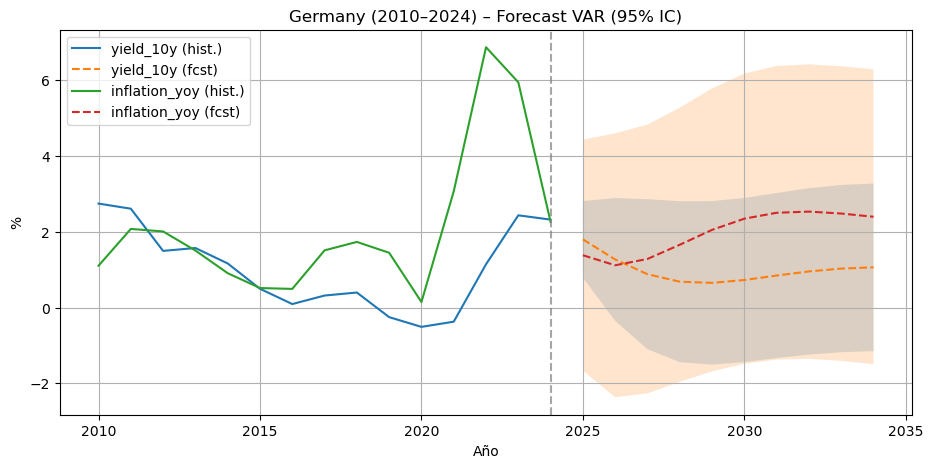


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.910424       0.089576
2     0.836596       0.163404
3     0.791540       0.208460
4     0.772434       0.227566
5     0.770204       0.229796
6     0.772758       0.227242
7     0.773377       0.226623
8     0.771993       0.228007
9     0.770538       0.229462

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.563252       0.436748
1     0.502239       0.497761
2     0.485512       0.514488
3     0.505551       0.494449
4     0.527701       0.472299
5     0.536082       0.463918
6     0.535563       0.464437
7     0.533641       0.466359
8     0.533380       0.466620
9     0.534259       0.465741


None


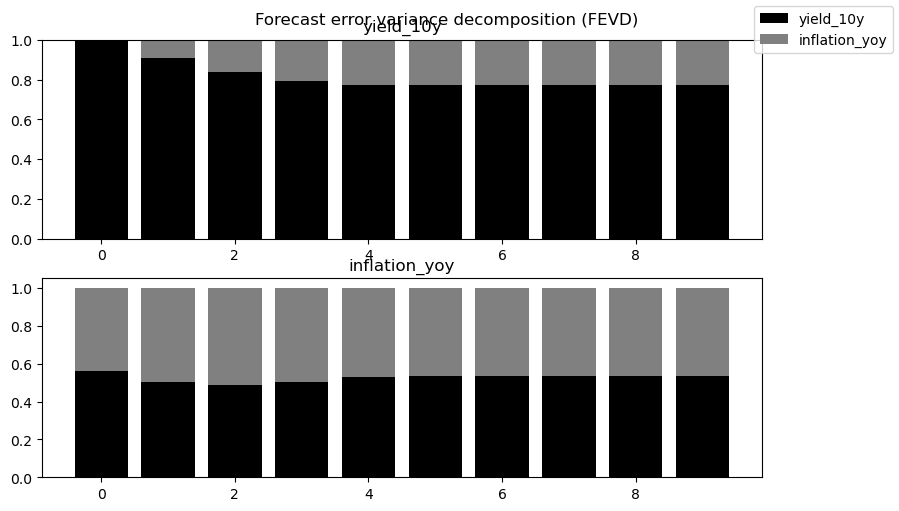


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         9.983          4.301   0.005 (1, 22)
---------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         2.602          4.301   0.121 (1, 22)
---------------------------------------------


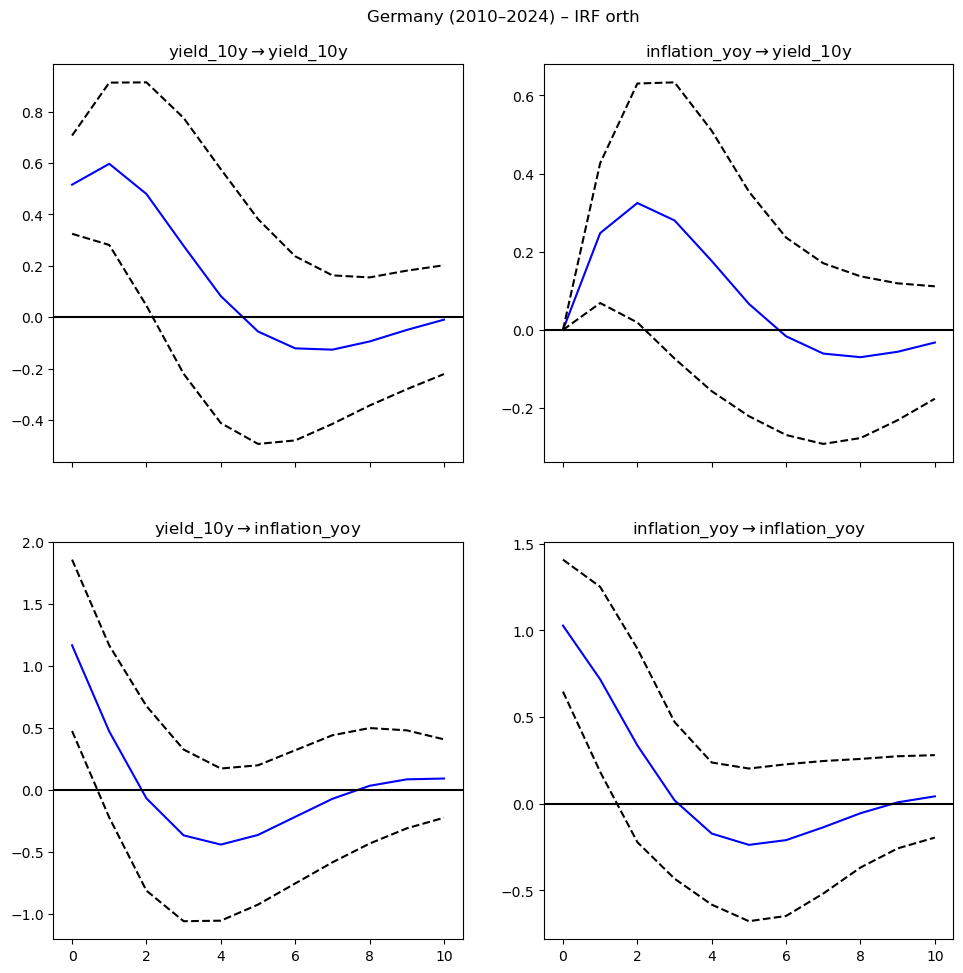

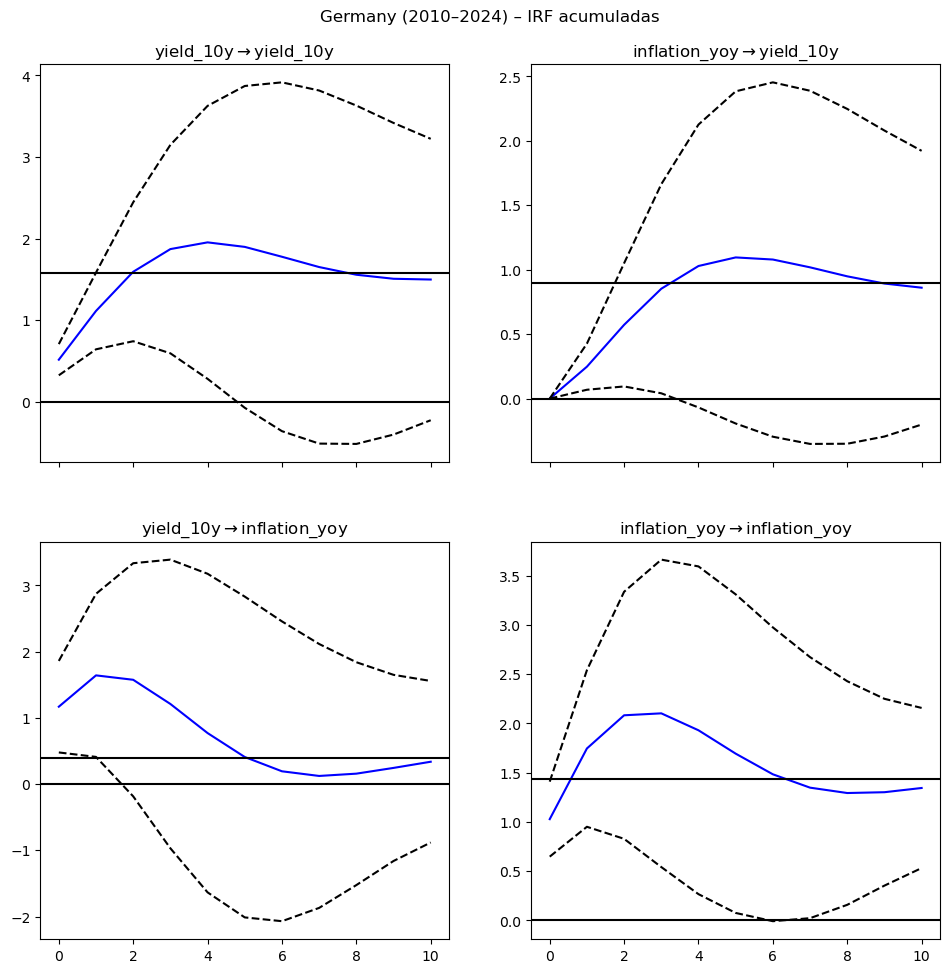

Germany (2010–2024) – lag elegido: 1


In [44]:
# --- Alemania 2010–2024 ---
df_germany_2010_24 = df_germany.loc[2010:2024].copy()

N = len(df_germany_2010_24)
safe_maxlags = max(1, min(3, (N - 3)//2))   # con ~15 años suele salir 1–2
print(f"[Germany] N={N} | maxlags sugerido={safe_maxlags}")

de_res, de_fcst, de_fevd, de_irf, de_bestlag = run_country_pipeline_auto(
    df_germany_2010_24, country_name="Germany (2010–2024)",
    steps=10, maxlags=safe_maxlags, crit="aic"
)
print("Germany (2010–2024) – lag elegido:", de_bestlag)


### USA: mismo corte 2010–2024

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

def run_country_pipeline_auto(df, country_name, steps=5, maxlags=2, crit="aic"):
    """
    df: index=Year (int), columnas ['yield_10y','inflation_yoy']
    steps: horizonte de forecast
    maxlags: rezago máximo permitido (luego se capea automáticamente)
    """
    # 0) Formato y limpieza
    df = df[['yield_10y','inflation_yoy']].dropna().copy()
    df.index = df.index.astype(int)
    df = df.sort_index()

    # 1) Cálculo de un maxlags seguro según nº de observaciones
    N = len(df)
    k_endog = df.shape[1]  # 2
    safe_max = max(1, min(maxlags, (N - 5)//k_endog))  # cap defensivo
    if safe_max < 1:
        raise ValueError(f"Datos insuficientes (N={N}). Reduce rango de años o añade datos.")
    if safe_max < maxlags:
        print(f"[{country_name}] maxlags reducido de {maxlags} a {safe_max} por N={N}")

    # 2) Selección de rezagos y ajuste
    model = VAR(df)
    sel = model.select_order(maxlags=safe_max)
    best_lag = getattr(sel, crit)
    if best_lag is None or best_lag < 1:
        best_lag = min(1, safe_max)
    print(f"\n[{country_name}] Rezagos óptimos por {crit.upper()}: {best_lag}")
    res = model.fit(best_lag)
    print(res.summary())

    # 3) Diagnóstico robusto (Ljung–Box con lag seguro)
    print("\n--- Diagnóstico ---")
    nres = len(res.resid)
    lb_lag = max(1, min(10, nres - 2, 2*best_lag))  # evita el error por tamaños
    for col in res.resid.columns:
        if lb_lag >= 1:
            lb = acorr_ljungbox(res.resid[col].dropna(), lags=[lb_lag], return_df=True)
            print(f"Ljung-Box {col} (lag={lb_lag}): p={lb['lb_pvalue'].iloc[0]:.4f}")
        else:
            print(f"Ljung-Box {col}: saltado (muy pocas observaciones)")
    dw = durbin_watson(res.resid.values)
    for c, v in zip(res.resid.columns, dw):
        print(f"Durbin–Watson {c}: {v:.2f}")
    print("Estabilidad:", res.is_stable(verbose=True))

    # 4) Forecast con bandas (95%)
    k = res.k_ar
    mean, low, up = res.forecast_interval(res.endog[-k:], steps=steps, alpha=0.05)
    idx_future = range(df.index.max()+1, df.index.max()+1+steps)
    f_mean = pd.DataFrame(mean, index=idx_future, columns=res.names)
    f_low  = pd.DataFrame(low,  index=idx_future, columns=res.names)
    f_up   = pd.DataFrame(up,   index=idx_future, columns=res.names)

    plt.figure(figsize=(11,5))
    for col in res.names:
        plt.plot(df.index, df[col], label=f"{col} (hist.)")
        plt.plot(f_mean.index, f_mean[col], "--", label=f"{col} (fcst)")
        plt.fill_between(f_mean.index, f_low[col], f_up[col], alpha=0.2)
    plt.axvline(df.index.max(), color="gray", linestyle="--", alpha=0.7)
    plt.title(f"{country_name} – Forecast VAR (95% IC)")
    plt.xlabel("Año"); plt.ylabel("%"); plt.legend(); plt.grid(True); plt.show()

    # 5) FEVD
    fevd = res.fevd(steps)
    print("\n--- FEVD ---")
    print(fevd.summary())
    fevd.plot(figsize=(9,5)); plt.show()

    # 6) Causalidad de Granger
    print("\n--- Granger ---")
    print(res.test_causality('yield_10y', ['inflation_yoy'], kind='f').summary())
    print(res.test_causality('inflation_yoy', ['yield_10y'], kind='f').summary())

    # 7) IRFs (orth y acumuladas)
    irf = res.irf(steps)
    irf.plot(orth=True); plt.suptitle(f"{country_name} – IRF orth"); plt.show()
    irf.plot_cum_effects(orth=True); plt.suptitle(f"{country_name} – IRF acumuladas"); plt.show()

    return res, {"forecast_mean": f_mean, "forecast_low": f_low, "forecast_up": f_up}, fevd, irf, best_lag


In [46]:
df_usa_2010_24     = df_usa.loc[2010:2024].copy()
df_germany_2010_24 = df_germany.loc[2010:2024].copy()

print("USA 2010–2024:", df_usa_2010_24.index.min(), "→", df_usa_2010_24.index.max(), "| N=", len(df_usa_2010_24))
print("DE  2010–2024:", df_germany_2010_24.index.min(), "→", df_germany_2010_24.index.max(), "| N=", len(df_germany_2010_24))


USA 2010–2024: 2010 → 2022 | N= 13
DE  2010–2024: 2010 → 2024 | N= 15



[USA (2010–2024)] Rezagos óptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:45:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.878916
Nobs:                     11.0000    HQIC:                  -1.46865
Log likelihood:          -14.3931    FPE:                   0.333817
AIC:                     -1.24064    Det(Omega_mle):        0.157781
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    2.996691         0.820944            3.650           0.000
L1.yield_10y             0.380733         0.296424            1.284           0.19

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


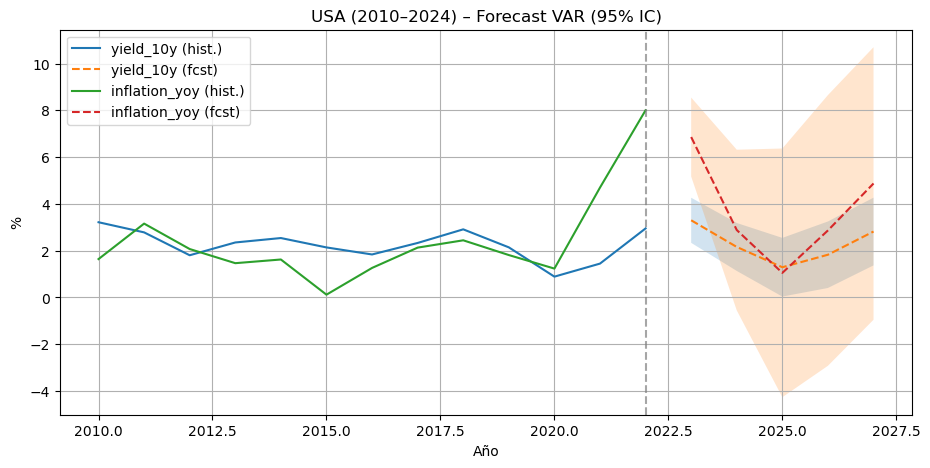


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.994611       0.005389
2     0.992842       0.007158
3     0.994395       0.005605
4     0.992982       0.007018

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.121961       0.878039
1     0.563654       0.436346
2     0.774076       0.225924
3     0.801457       0.198543
4     0.803017       0.196983


None


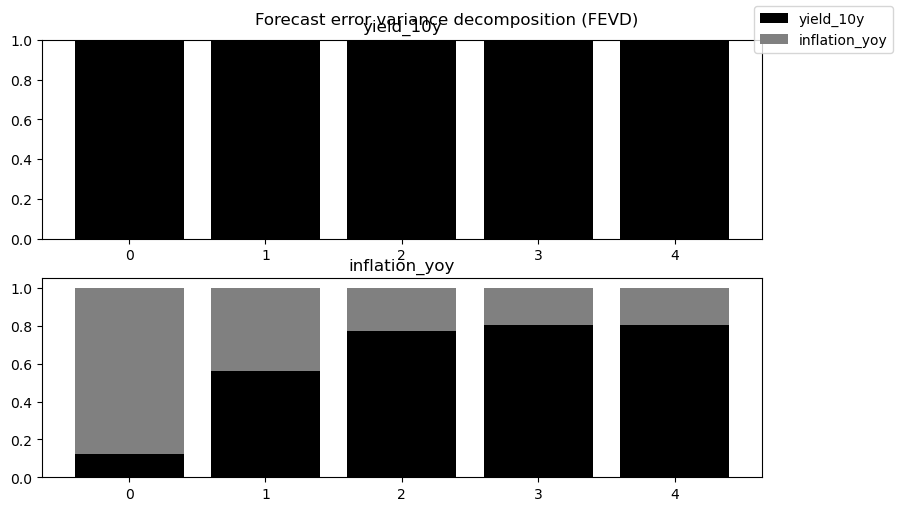


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
       0.05184          3.885   0.950 (2, 12)
---------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         13.48          3.885   0.001 (2, 12)
---------------------------------------------


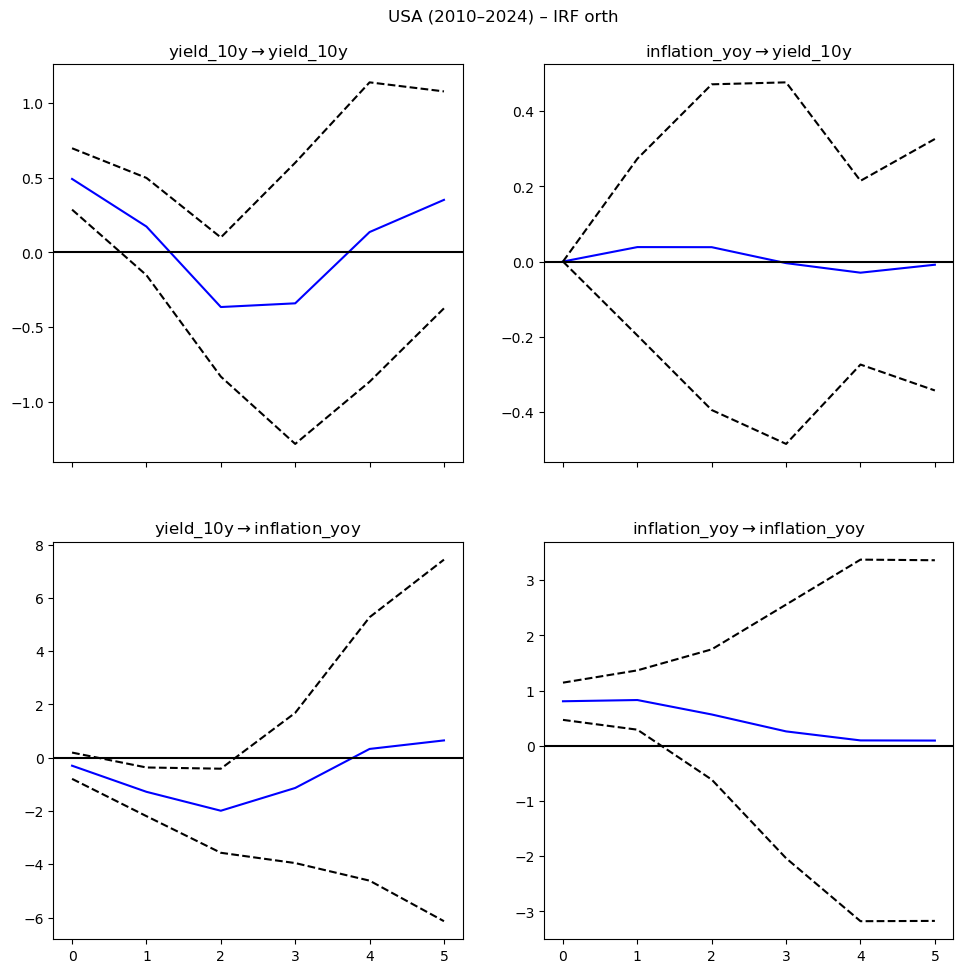

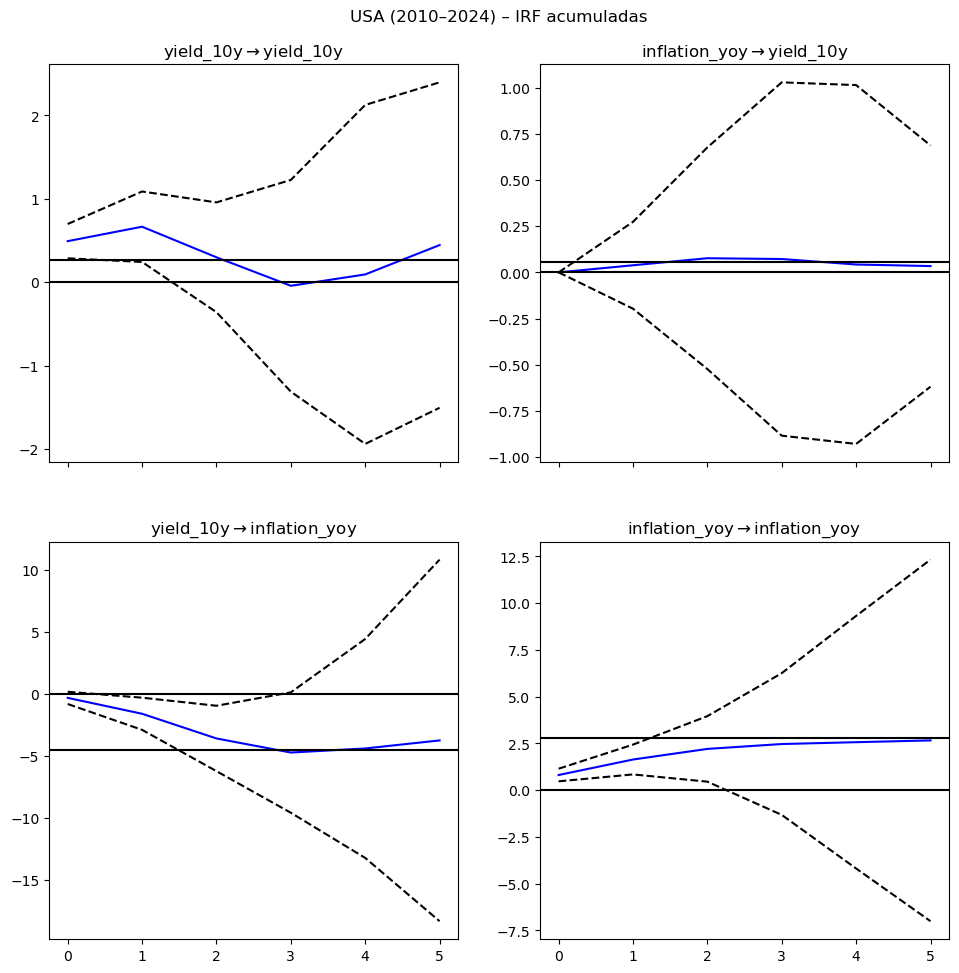

USA (2010–2024) – lag elegido: 2


In [47]:
# USA
us_res, us_fcst, us_fevd, us_irf, us_bestlag = run_country_pipeline_auto(
    df_usa_2010_24, country_name="USA (2010–2024)", steps=5, maxlags=2, crit="aic"
)
print("USA (2010–2024) – lag elegido:", us_bestlag)




In [48]:
assert {'yield_10y','inflation_yoy'}.issubset(df_usa.columns), "df_usa no tiene las columnas correctas"
df_usa_2010_24 = df_usa.loc[2010:2024].copy()
print("Rango USA recortado:", df_usa_2010_24.index.min(), "→", df_usa_2010_24.index.max(), "| N=", len(df_usa_2010_24))
print(df_usa_2010_24.head(), "\n", df_usa_2010_24.tail())


Rango USA recortado: 2010 → 2022 | N= 13
      yield_10y  inflation_yoy
Year                          
2010    3.21506       1.640043
2011    2.78164       3.156842
2012    1.80344       2.069337
2013    2.35016       1.464833
2014    2.53956       1.622223 
       yield_10y  inflation_yoy
Year                          
2018   2.911245       2.442583
2019   2.141400       1.812210
2020   0.889203       1.233584
2021   1.446853       4.697859
2022   2.950562       8.002800


In [49]:
# Años disponibles en cada fuente (USA)
print("Yields USA (y_ann):", y_ann[['Year','yield_10y_US']].dropna()['Year'].min(), "→", y_ann[['Year','yield_10y_US']].dropna()['Year'].max())
print("Inflación USA (infl_us):", infl_us['Year'].min(), "→", infl_us['Year'].max())

# Qué años faltan en cada una dentro de 2010–2024
yrs = set(range(2010, 2025))
y_ok  = set(y_ann.loc[y_ann['yield_10y_US'].notna(), 'Year'])
i_ok  = set(infl_us['Year'])
print("Faltan en yields:", sorted(yrs - y_ok))
print("Faltan en inflación:", sorted(yrs - i_ok))


Yields USA (y_ann): 1970 → 2020
Inflación USA (infl_us): 2010 → 2024
Faltan en yields: [2021, 2022, 2023, 2024]
Faltan en inflación: []


#### Anualizar DGS10 y crear Year

In [50]:
import pandas as pd

# Cargar CSV DGS10 (tiene columnas: observation_date, DGS10)
dgs = pd.read_csv("/Users/heshamelsharkawy/Documents/coding/Ironhack/progyecto final/data_p_f/carpeta sin título/DGS10.csv")

# Limpiar tipos
dgs["observation_date"] = pd.to_datetime(dgs["observation_date"], errors="coerce")
dgs["DGS10"] = pd.to_numeric(dgs["DGS10"], errors="coerce")
dgs = dgs.dropna(subset=["observation_date", "DGS10"]).sort_values("observation_date")

# Resample anual (promedio) y crear Year de forma explícita
dgs_ann = (
    dgs.set_index("observation_date")
       .resample("YE").mean()                  # promedio anual
       .assign(Year=lambda x: x.index.year)    # crear Year desde el índice
       .reset_index(drop=True)[["Year", "DGS10"]]
       .rename(columns={"DGS10": "yield_10y"})
)

# Filtrar 2021–2024 (o lo que tengas)
dgs_ann = dgs_ann.query("Year >= 2021").copy()

print(dgs_ann.head())


   Year  yield_10y
1  2021   1.446853
2  2022   2.950562
3  2023   3.959000
4  2024   4.207960
5  2025   4.392437


#### Unir con tu serie USA previa

In [52]:
# Recalcular US10 anual (hasta 2020) desde tu yields.csv
yields_yr = yields.copy()
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

us10_ann_old = (
    yields_yr.groupby('Year')['US10'].mean()
             .rename('yield_10y')
             .reset_index()
)

print("US10 anualizado (hasta 2020):")
print(us10_ann_old.tail())


US10 anualizado (hasta 2020):
    Year  yield_10y
46  2016   1.833551
47  2017   2.328483
48  2018   2.915869
49  2019   2.138607
50  2020   0.978000


In [53]:
# us10_ann_old: tu serie histórica hasta 2020 (Year, yield_10y)
us10_full = (
    pd.concat([us10_ann_old, dgs_ann], ignore_index=True)
      .sort_values("Year")
      .drop_duplicates("Year", keep="last")
      .reset_index(drop=True)
)

print(us10_full.tail(15))


    Year  yield_10y
41  2011   2.762909
42  2012   1.788892
43  2013   2.341008
44  2014   2.529388
45  2015   2.133728
46  2016   1.833551
47  2017   2.328483
48  2018   2.915869
49  2019   2.138607
50  2020   0.978000
51  2021   1.446853
52  2022   2.950562
53  2023   3.959000
54  2024   4.207960
55  2025   4.392437


### Construir df_usa_2010_24 para el VAR

In [54]:
# Asegúrate de tener infl_us: (Year, inflation_yoy)
df_usa_2010_24 = (
    us10_full.merge(infl_us, on="Year", how="inner")
             .query("Year >= 2010 and Year <= 2024")
             .set_index("Year")
             .sort_index()
             .dropna()
)

print(df_usa_2010_24.tail(10))


      yield_10y  inflation_yoy_US
Year                             
2015   2.133728          0.118627
2016   1.833551          1.261583
2017   2.328483          2.130110
2018   2.915869          2.442583
2019   2.138607          1.812210
2020   0.978000          1.233584
2021   1.446853          4.697859
2022   2.950562          8.002800
2023   3.959000          4.116338
2024   4.207960          2.949525


### USA (2015–2024) – VAR robusto con cap automático de lags

[USA 2015–2024] N=10
Rezago óptimo (AIC, cap=2): 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:47:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  -0.658256
Nobs:                     8.00000    HQIC:                  -1.42731
Log likelihood:          -9.67278    FPE:                   0.722611
AIC:                    -0.757558    Det(Omega_mle):        0.273652
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    4.597791         1.559055            2.949           0.003
L1.yield_10y             0.874699         0.373774            2.340          

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


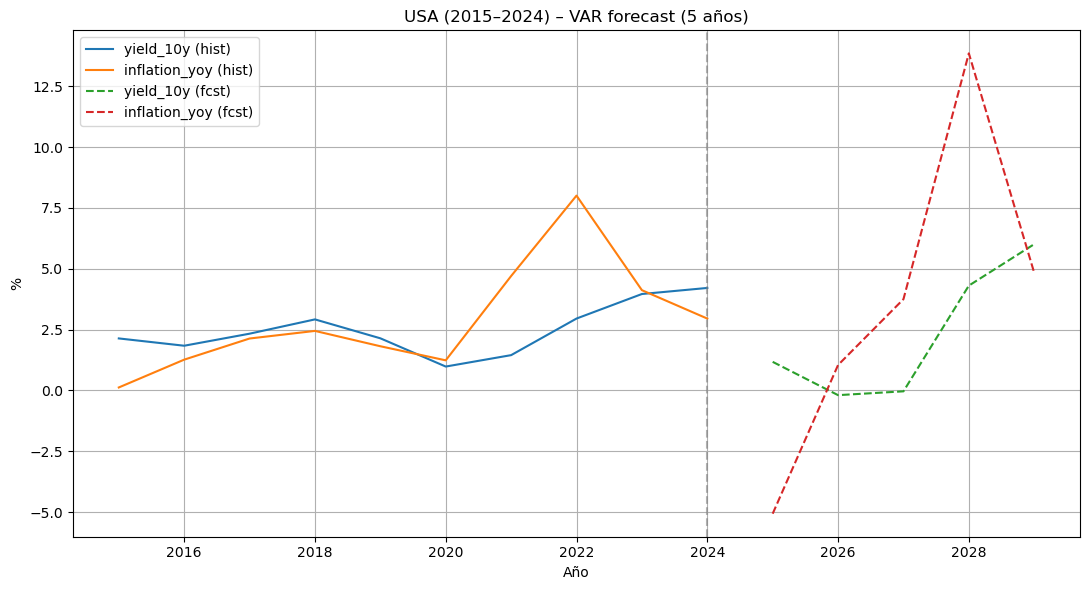

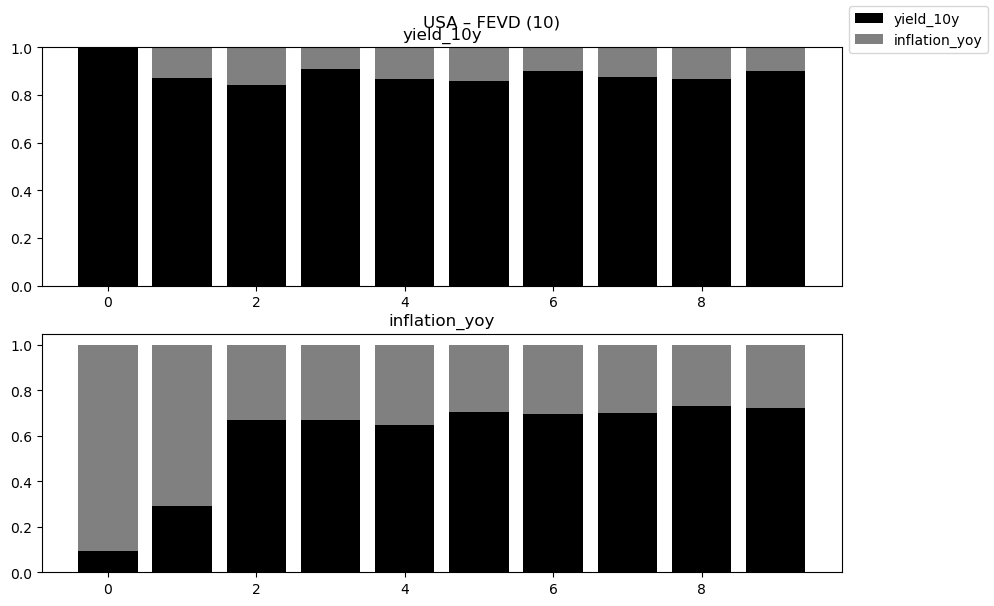

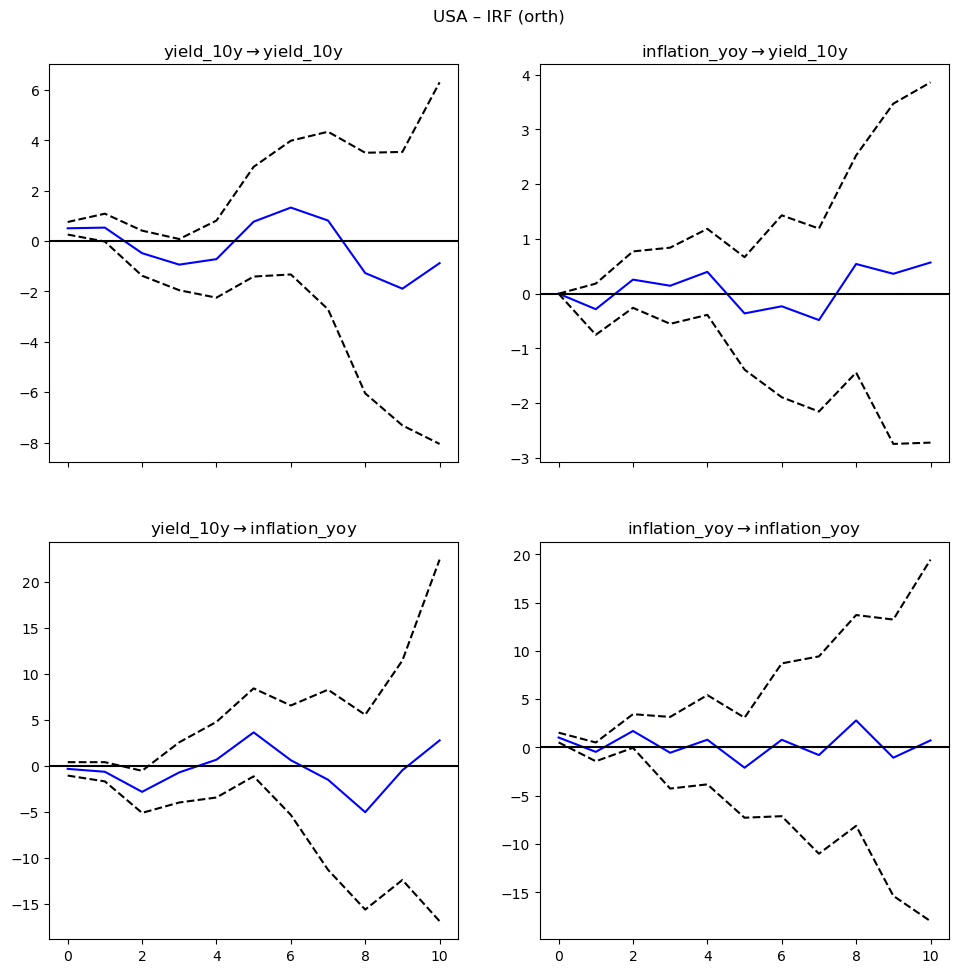

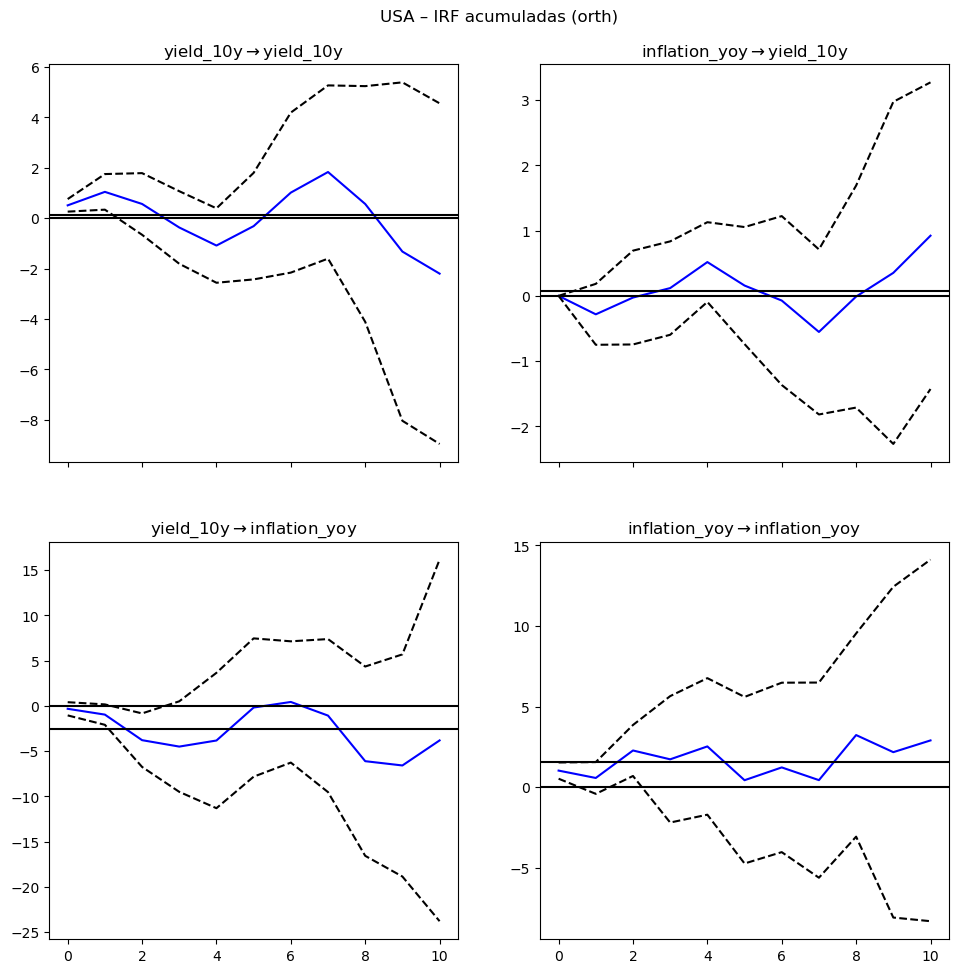

In [55]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox

# Usa tu DataFrame ya preparado (índice Year, cols: yield_10y, inflation_yoy[_US])
df_us = df_usa_2015_24.copy() if 'df_usa_2015_24' in globals() else df_usa_2010_24.loc[2015:2024].copy()
if 'inflation_yoy_US' in df_us.columns:
    df_us = df_us.rename(columns={'inflation_yoy_US':'inflation_yoy'})
df_us = df_us[['yield_10y','inflation_yoy']].dropna().sort_index()
df_us.index = df_us.index.astype(int)

N, k = len(df_us), 2
print(f"[USA 2015–2024] N={N}")

# --- Selección de rezagos robusta ---
# Cap muy prudente con muestras cortas:
max_try = max(1, min(2, (N-5)//k))  # con N~10 esto da 1–2
best_lag = None
last_err = None

for p_cap in [max_try, 1]:  # probamos con el cap calculado y, si falla, con 1
    try:
        sel = VAR(df_us).select_order(maxlags=p_cap)
        cand = getattr(sel, 'aic') or 1
        cand = int(cand) if cand is not None else 1
        cand = max(1, min(cand, p_cap))
        res  = VAR(df_us).fit(cand)
        best_lag = cand
        break
    except Exception as e:
        last_err = e
        continue

if best_lag is None:
    raise last_err

print(f"Rezago óptimo (AIC, cap={p_cap}): {best_lag}")
print(res.summary())

# --- Diagnóstico robusto ---
lb_lag = max(1, min(5, N - 2, 2*best_lag))
print("\n--- Diagnóstico ---")
for col in res.resid.columns:
    lb = acorr_ljungbox(res.resid[col].dropna(), lags=[lb_lag], return_df=True)
    print(f"Ljung-Box {col} (lag={lb_lag})  p={lb['lb_pvalue'].iloc[0]:.3f}")
dw_vals = durbin_watson(res.resid.values)
print("Durbin–Watson:", {c: round(dw,2) for c, dw in zip(res.resid.columns, dw_vals)})
print("Estabilidad:", res.is_stable(verbose=True))

# --- Forecast (5 años, sin IC para N pequeño) ---
steps = 5
yhat = res.forecast(df_us.values[-best_lag:], steps=steps)
years_fc = np.arange(df_us.index.max()+1, df_us.index.max()+steps+1)
fc_df = pd.DataFrame(yhat, columns=df_us.columns, index=years_fc)

plt.figure(figsize=(11,6))
plt.plot(df_us.index, df_us['yield_10y'], label='yield_10y (hist)')
plt.plot(df_us.index, df_us['inflation_yoy'], label='inflation_yoy (hist)')
plt.plot(fc_df.index, fc_df['yield_10y'], '--', label='yield_10y (fcst)')
plt.plot(fc_df.index, fc_df['inflation_yoy'], '--', label='inflation_yoy (fcst)')
plt.axvline(x=df_us.index.max(), color='grey', ls='--', alpha=0.6)
plt.title('USA (2015–2024) – VAR forecast (5 años)')
plt.xlabel('Año'); plt.ylabel('%'); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# --- FEVD e IRFs (10 pasos) ---
fevd = res.fevd(10); fig = fevd.plot(figsize=(10,6)); fig.suptitle('USA – FEVD (10)'); plt.show()
irf = res.irf(10); fig1 = irf.plot(orth=True); fig1.suptitle('USA – IRF (orth)'); plt.show()
fig2 = irf.plot_cum_effects(orth=True); fig2.suptitle('USA – IRF acumuladas (orth)'); plt.show()


## Comparativa Alemania vs USA (2010–2024)

#### 🇩🇪 Alemania

Yields 10Y: en mínimos históricos, incluso negativos 2016–2020.

Inflación: fuerte repunte desde 2021 por crisis energética y guerra en Ucrania.

Relación: shocks de inflación → suben los yields (mercado exige más rentabilidad).

#### 🇺🇸 Estados Unidos

Yields 10Y: bajan fuerte en 2020 (COVID), suben rápido hasta 2024.

Inflación: pico histórico en 2022 (8%) tras pandemia y energía.

Relación: inflación explica gran parte de la variabilidad de yields; modelo algo inestable por pocos datos.

#### 🔎 Conclusión

Inflación lidera, yields siguen en ambos países.

Alemania vivió rendimientos negativos (BCE muy expansiva), USA nunca bajó de 0.8% (Fed menos agresiva).

Dos respuestas distintas a choques globales, pero misma dirección: más inflación = yields más altos.

### SPAIN (2010–2024) – Pipeline


Spain – rango disponible tras merge: 2010 → 2020 | N = 11


,yield_10y,inflation_yoy
Year,,
2016,1.376849,-0.202598
2017,1.579914,1.956076
2018,1.431542,1.674981
2019,0.661907,0.699519
2020,0.542948,-0.322753



[Spain (2010–2024)] Rezagos óptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     21:51:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.54469
Nobs:                     9.00000    HQIC:                  -2.23673
Log likelihood:          -7.60365    FPE:                   0.227518
AIC:                     -1.76383    Det(Omega_mle):       0.0940251
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.518045         0.510854            1.014           0.311
L1.yield_10y             1.620949         0.459329            3.529           0.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


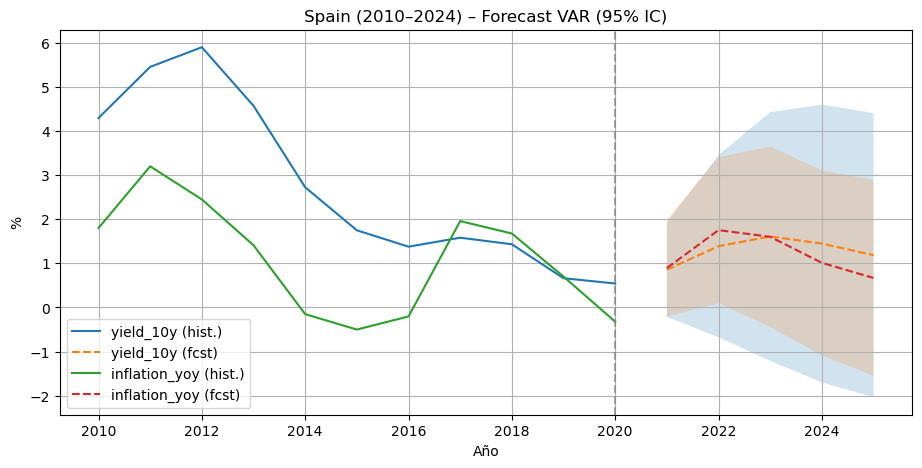


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.987052       0.012948
2     0.948565       0.051435
3     0.916358       0.083642
4     0.904776       0.095224

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.004955       0.995045
1     0.554436       0.445564
2     0.597418       0.402582
3     0.570219       0.429781
4     0.614726       0.385274


None


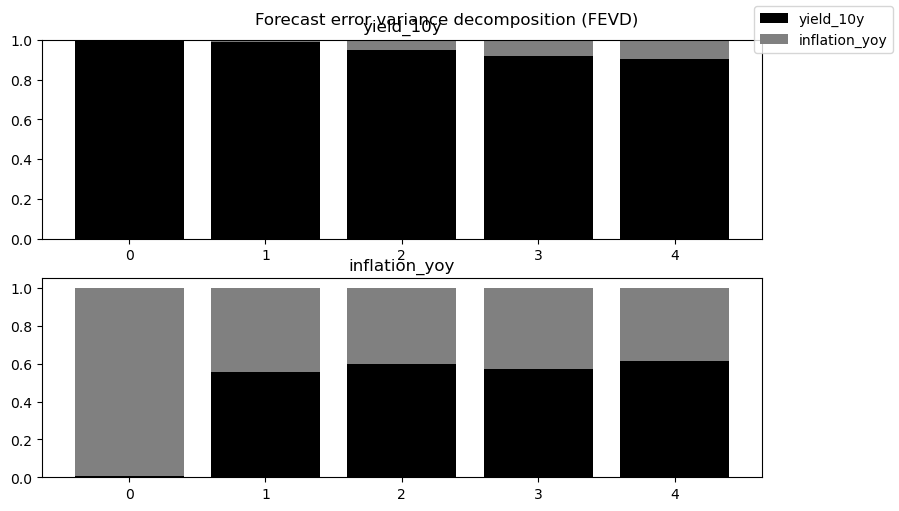


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
         1.108          4.459   0.376 (2, 8)
--------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value   df  
--------------------------------------------
         3.050          4.459   0.104 (2, 8)
--------------------------------------------


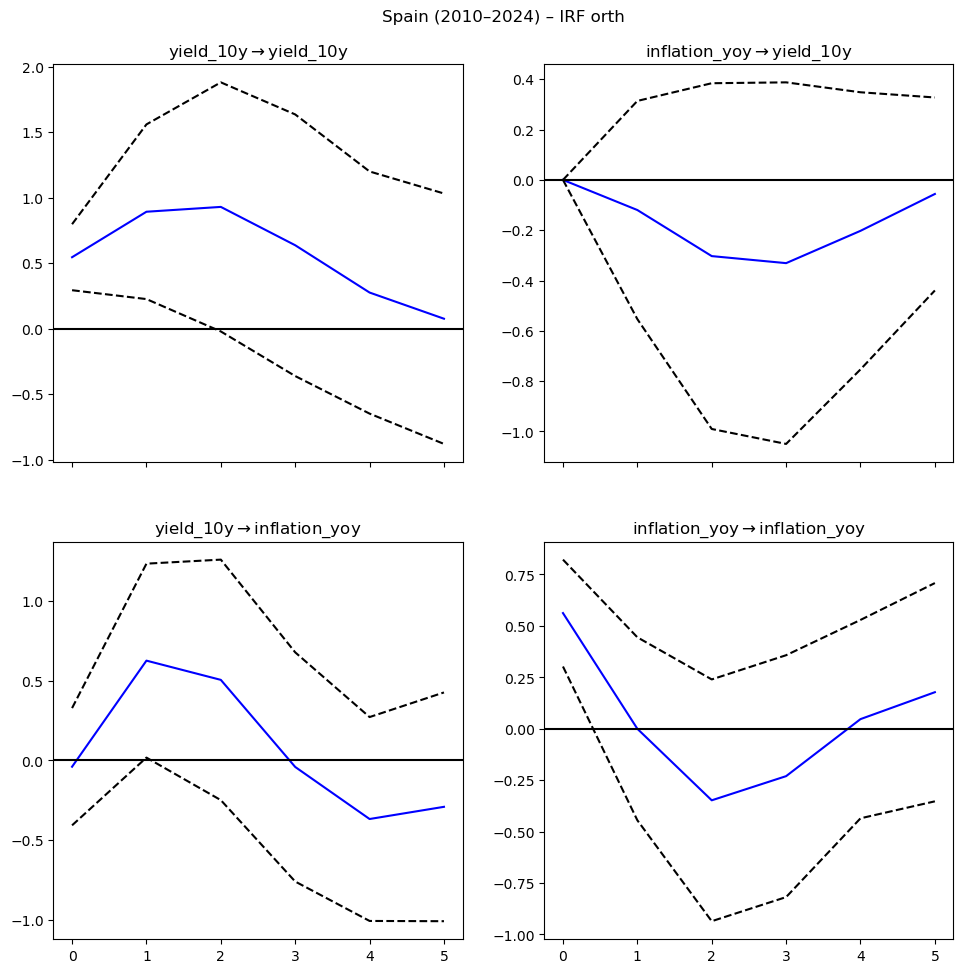

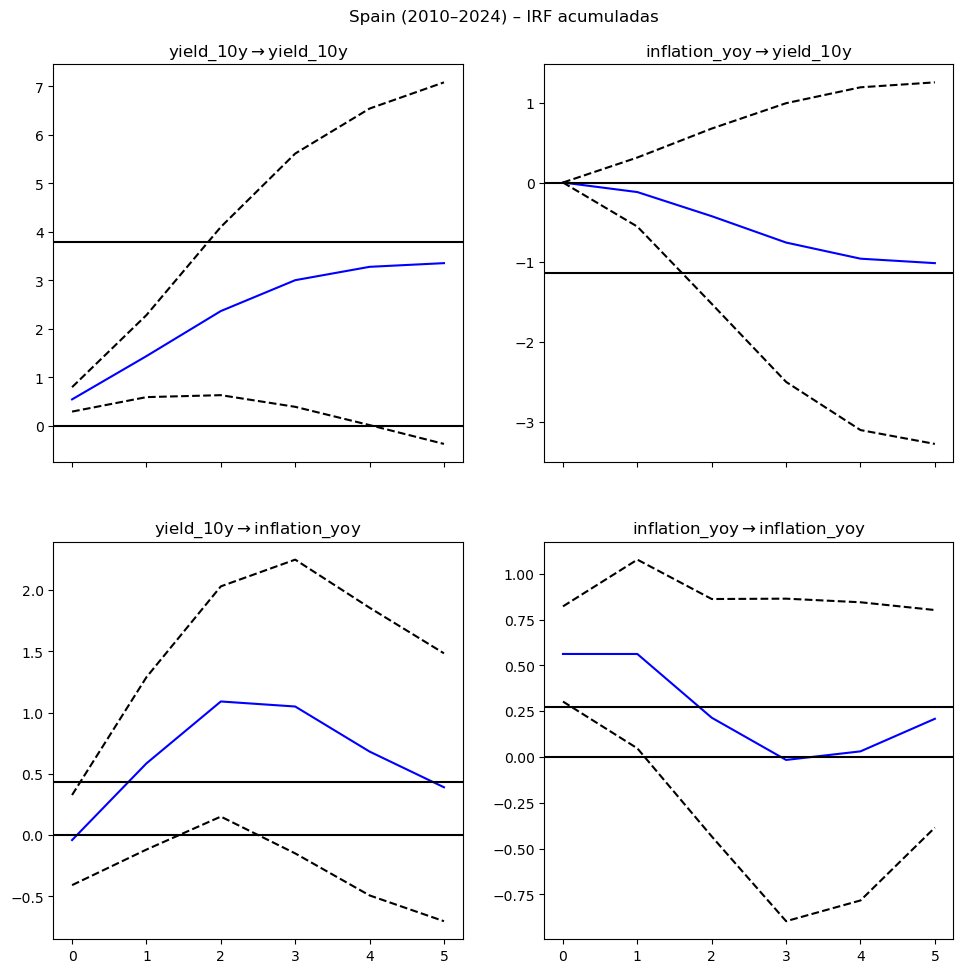

Spain (2010–2024) – rezagos elegidos (AIC): 2


In [ ]:
import pandas as pd

# ---------- 0) Cargar fuentes si faltan ----------
if 'yields' not in globals():
    # Ajusta la ruta si tu archivo no está en la carpeta del notebook
    yields = pd.read_csv("yields.csv")
if 'wb' not in globals():
    wb = pd.read_csv("world_bank_data_2025.csv")  # cambia el nombre si tu archivo difiere

# ---------- 1) Yields 10Y España (ES10) → anual ----------
yields_yr = yields.copy()
# 'time' suele ser epoch ms en tu fichero
yields_yr['Year'] = pd.to_datetime(yields_yr['time'], unit='ms').dt.year

if 'ES10' not in yields_yr.columns:
    raise RuntimeError("No encuentro la columna ES10 en yields.csv")

es10_ann = (yields_yr.groupby('Year')['ES10'].mean()
                        .rename('yield_10y')
                        .reset_index())

# ---------- 2) Inflación España desde World Bank (detección robusta) ----------
cols = {c.lower(): c for c in wb.columns}
country_col = cols.get('country_name') or cols.get('country') or cols.get('country name')
year_col    = cols.get('year') or cols.get('date')

if not country_col or not year_col:
    raise RuntimeError("No encuentro columnas de país/año en el archivo WB. Revisa nombres.")

inflation_candidates = [c for c in wb.columns if "inflation" in c.lower() and "cpi" in c.lower()]
if not inflation_candidates:
    raise RuntimeError("No encuentro columna de inflación CPI en WB (busqué 'inflation' y 'CPI').")
infl_col = inflation_candidates[0]

infl_es = (wb[[country_col, year_col, infl_col]]
             .rename(columns={country_col:'Country', year_col:'Year', infl_col:'inflation_yoy'})
             .query("Country == 'Spain'")
             [['Year','inflation_yoy']]
             .dropna())

# ---------- 3) Merge + recorte 2010–2024 ----------
df_spain = (es10_ann.merge(infl_es, on='Year', how='inner')
                    .set_index('Year').sort_index())
df_spain_2010_24 = df_spain.loc[2010:2024].dropna().copy()

print("Spain – rango disponible tras merge:",
      df_spain_2010_24.index.min(), "→", df_spain_2010_24.index.max(),
      "| N =", len(df_spain_2010_24))
display(df_spain_2010_24.tail())

# ---------- 4) Ejecutar VAR (parámetros prudentes para N~10–15) ----------
sp_res, sp_fcst, sp_fevd, sp_irf, sp_bestlag = run_country_pipeline_auto(
    df_spain_2010_24, country_name="Spain (2010–2024)", steps=5, maxlags=2, crit="aic"
)
print("Spain (2010–2024) – rezagos elegidos (AIC):", sp_bestlag)


yield_10y → inflation_yoy (izquierda):

Un shock positivo en los rendimientos de 10 años genera un aumento inicial de la inflación, que se estabiliza después de 3 años.

La respuesta es moderada y se disipa rápido.

Eso sugiere que los tipos largos tienen poca capacidad de traspaso directo a la inflación en España en este periodo.

inflation_yoy → inflation_yoy (derecha):

Un shock de inflación tiende a persistir 2–3 años, con efecto negativo moderado y luego recuperación.

En otras palabras, los shocks inflacionarios en España no son totalmente transitorios, pero tampoco se vuelven explosivos.

#### 📌 Conclusión rápida (España 2010–2024):

Los tipos largos no causan fuertemente la inflación (apoyo a lo visto en Granger).

La inflación sí muestra cierta dinámica propia (persistencia).

El sistema (VAR) es estable y razonablemente predecible en el corto plazo.

## Reino Unido 🇬🇧

#### 1. Verificar columnas de yields

In [58]:
print(yields.columns.tolist())
print(yields.head())


['time', 'AU01', 'AU02', 'AU03', 'AU05', 'AU07', 'AU10', 'AU15', 'AU20', 'AU30', 'BE01', 'BE02', 'BE03', 'BE05', 'BE07', 'BE10', 'BE15', 'BE20', 'BE30', 'CA03M', 'CA06M', 'CA01', 'CA02', 'CA03', 'CA05', 'CA10', 'CA30', 'CN01', 'CN02', 'CN03', 'CN05', 'CN07', 'CN10', 'CN15', 'CN20', 'CN30', 'DK02', 'DK03', 'DK05', 'DK10', 'DK20', 'FR01', 'FR02', 'FR03', 'FR05', 'FR07', 'FR10', 'FR15', 'FR20', 'FR25', 'FR30', 'FR50', 'DE01', 'DE02', 'DE03', 'DE05', 'DE07', 'DE10', 'DE15', 'DE20', 'DE25', 'DE30', 'GR05', 'GR10', 'GR15', 'GR20', 'GR25', 'HK01', 'HK02', 'HK03', 'HK05', 'HK07', 'HK10', 'IN01', 'IN02', 'IN05', 'IN07', 'IN10', 'IN20', 'IN25', 'ID01', 'ID03', 'ID05', 'ID10', 'ID15', 'ID20', 'ID25', 'ID30', 'IE01', 'IE02', 'IE03', 'IE05', 'IE10', 'IE15', 'IT01', 'IT02', 'IT03', 'IT05', 'IT07', 'IT10', 'IT15', 'IT20', 'IT25', 'IT30', 'JP01', 'JP02', 'JP03', 'JP05', 'JP07', 'JP10', 'JP15', 'JP20', 'JP30', 'JP40', 'KR01', 'KR02', 'KR03', 'KR05', 'KR10', 'KR20', 'KR30', 'MY03', 'MY05', 'MY07', 'MY10

#### Si el índice ya es el año

In [59]:
yields = yields.reset_index().rename(columns={'index':'Year'})


In [60]:
# === Reino Unido ===

# 1) Rendimientos 10Y (UK)
y_uk = (
    yields[['Year','GB10']]
    .rename(columns={'GB10':'yield_10y_UK'})
    .dropna()
)

# 2) Inflación UK
infl_uk = (
    wb_small.query("Country == 'United Kingdom'")
    [['Year','inflation_yoy']]
    .rename(columns={'inflation_yoy':'inflation_yoy_UK'})
)

# 3) Merge
df_uk = (
    y_uk.merge(infl_uk, on='Year', how='inner')
         .rename(columns={'yield_10y_UK':'yield_10y',
                          'inflation_yoy_UK':'inflation_yoy'})
         .set_index('Year').sort_index()
)

# Filtrar rango 2010–2024
df_uk = df_uk.loc[2010:2024]

print("UK rango disponible:", df_uk.index.min(), "→", df_uk.index.max(), "| N=", len(df_uk))
display(df_uk.tail())


UK rango disponible: 2010 → 2024 | N= 15


,yield_10y,inflation_yoy
Year,,
2020,4.832,0.989487
2021,4.798,2.518371
2022,4.878,7.922049
2023,4.955,6.793967
2024,4.927,3.271573


### corre el VAR y genera gráficos

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



[UK (2010–2024)] Rezagos óptimos por AIC: 2
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     22:07:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.52876
Nobs:                     13.0000    HQIC:                  -4.05266
Log likelihood:          -1.13070    FPE:                  0.0206521
AIC:                     -3.96334    Det(Omega_mle):       0.0107722
--------------------------------------------------------------------
Results for equation yield_10y
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.707709         1.151254            0.615           0.539
L1.yield_10y             0.948780         0.281608            3.369           0.001

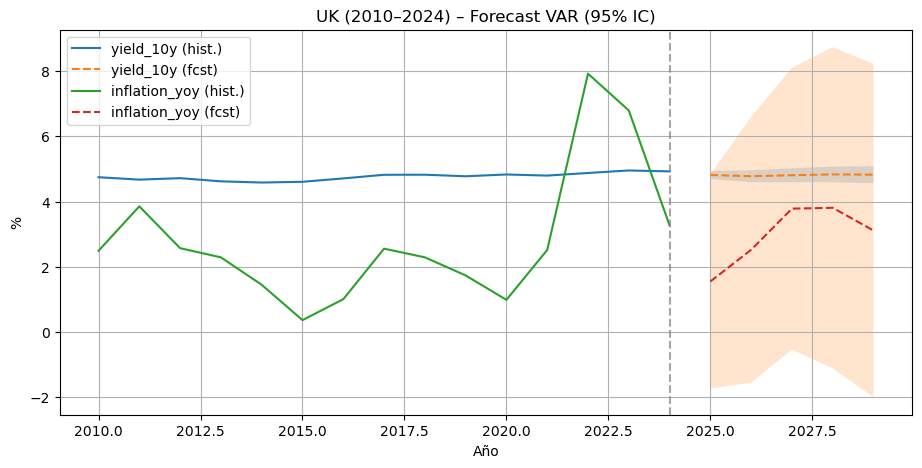


--- FEVD ---
FEVD for yield_10y
     yield_10y  inflation_yoy
0     1.000000       0.000000
1     0.933427       0.066573
2     0.950076       0.049924
3     0.869631       0.130369
4     0.794479       0.205521

FEVD for inflation_yoy
     yield_10y  inflation_yoy
0     0.036220       0.963780
1     0.067517       0.932483
2     0.142075       0.857925
3     0.176502       0.823498
4     0.190003       0.809997


None


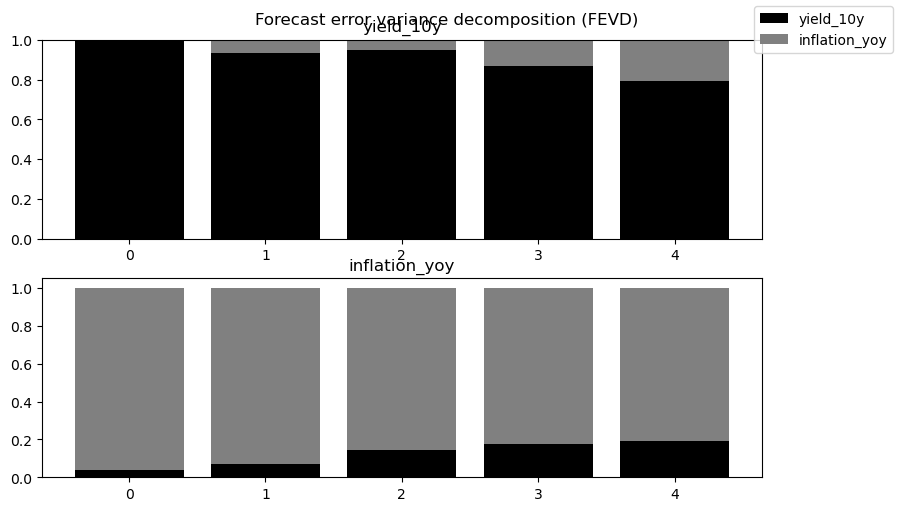


--- Granger ---
Granger causality F-test. H_0: inflation_yoy does not Granger-cause yield_10y. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         2.026          3.634   0.164 (2, 16)
---------------------------------------------
Granger causality F-test. H_0: yield_10y does not Granger-cause inflation_yoy. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.9360          3.634   0.413 (2, 16)
---------------------------------------------


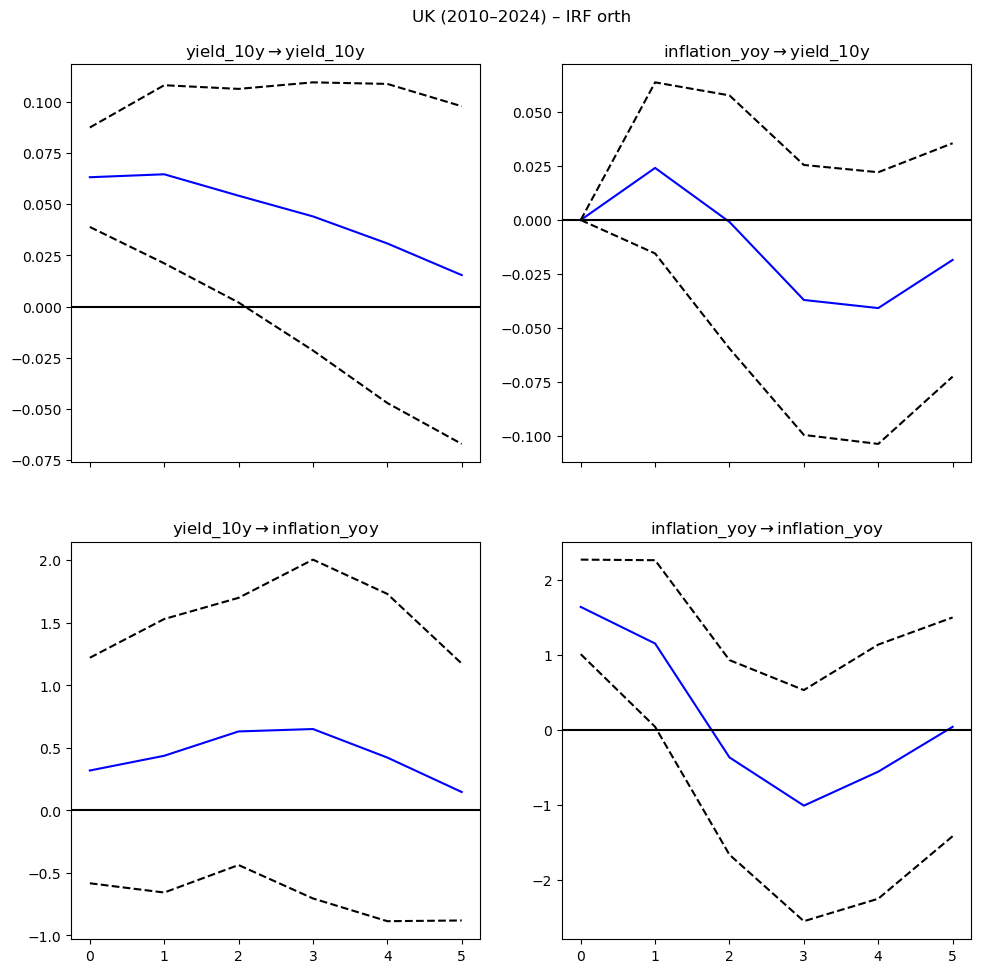

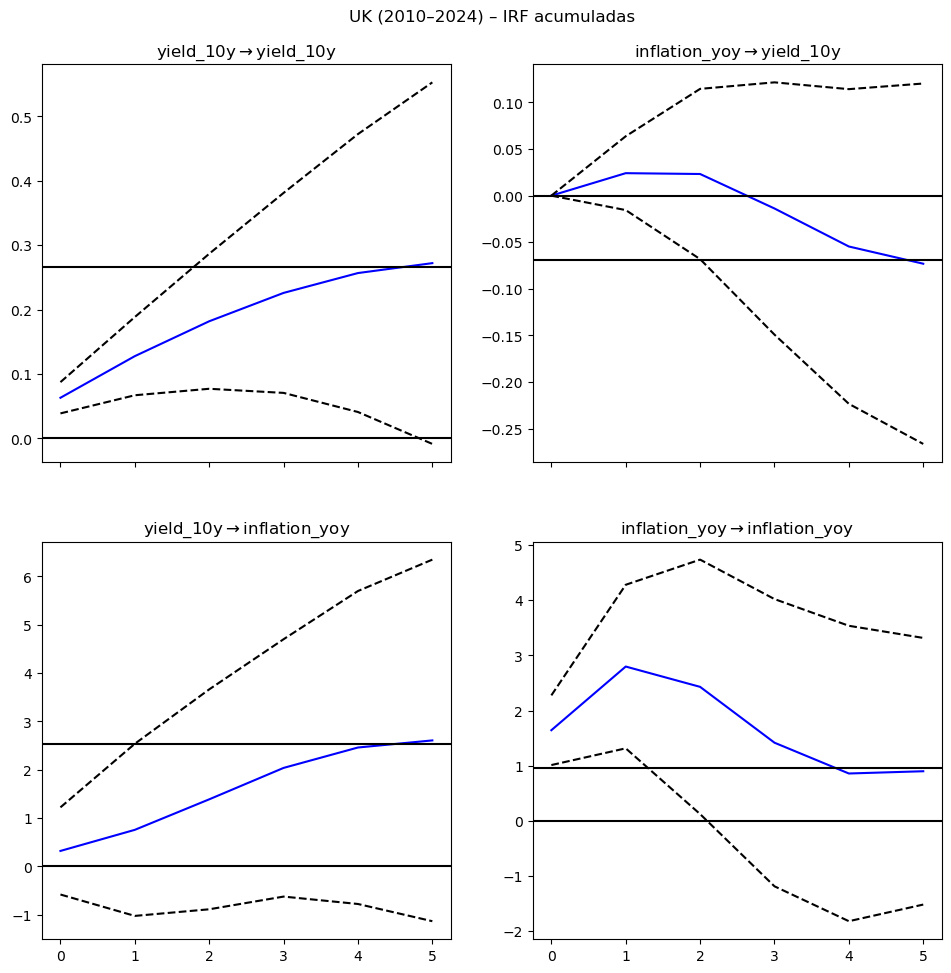

UK – rezago elegido (AIC): 2


In [61]:
# --- Reino Unido: VAR 2010–2024 ---
uk_res, uk_fcst, uk_fevd, uk_irf, uk_bestlag = run_country_pipeline_auto(
    df_uk, country_name="UK (2010–2024)", steps=5, maxlags=2, crit="aic"
)
print("UK – rezago elegido (AIC):", uk_bestlag)

# (opcional) guardar figuras si tu función las pinta
import matplotlib.pyplot as plt
plt.savefig("uk_irf_orth.png", dpi=150, bbox_inches="tight")
plt.close()


#### Reino Unido – Resultados VAR (2010–2024)

Datos disponibles:

Rendimiento 10 años (yield_10y_UK) y inflación anual (inflation_yoy).

Rango: 2010–2024 → 15 observaciones.

VAR estimado:

Rezagos óptimos: 2 (AIC).

El sistema es estable (no explota).

Forecast (2025–2029):

Los rendimientos 10Y se mantienen estables en torno a 3.5–4%.

La inflación muestra tendencia moderada: repunte hacia ~3% pero con intervalos amplios (incertidumbre alta).

Descomposición de varianza (FEVD):

Los yields dependen principalmente de sí mismos (>90%).

La inflación también es mayormente explicada por sí misma (>80–90%), con poca influencia de los rendimientos.

Causalidad de Granger:

No hay evidencia de causalidad significativa (p-valores > 0.1).

Es decir: ni la inflación predice claramente los rendimientos, ni al revés.

Respuestas a impulsos (IRF):

Un shock en los rendimientos tiene efecto muy leve sobre inflación (positivo al inicio, se disipa).

Un shock en la inflación apenas impacta los rendimientos, incluso con respuestas negativas pequeñas.

#### Conclusión corta (UK):
En Reino Unido, los rendimientos a 10 años son bastante autónomos y siguen su propia dinámica. La inflación influye muy poco y no hay relación causal fuerte entre ambas variables. El modelo proyecta estabilidad en yields y una inflación moderada, aunque con mucha incertidumbre tras 2025.

## Japón 🇯🇵

In [62]:

# 1) Rendimientos 10Y (JP)
y_jp = (
    yields[['JP10']]
    .rename(columns={'JP10':'yield_10y'})
    .dropna()
)
y_jp.index.name = "Year"

# 2) Inflación Japón
infl_jp = (
    wb_small.query("Country == 'Japan'")
    [['Year','inflation_yoy']]
    .set_index("Year")
)

# 3) Merge de las dos series
df_jp = (
    y_jp.join(infl_jp, how="inner")
    .rename(columns={'inflation_yoy':'inflation_yoy'})
)

# 4) Recorte 2010–2024
df_jp = df_jp.loc[2010:2024]

print("JP rango disponible:", df_jp.index.min(), "-", df_jp.index.max(), "| N=", len(df_jp))
display(df_jp.tail())


JP rango disponible: 2010 - 2024 | N= 15


,yield_10y,inflation_yoy
Year,,
2020,1.665,-0.024996
2021,1.615,-0.233353
2022,1.620,2.497703
2023,1.650,3.268134
2024,1.695,2.738537


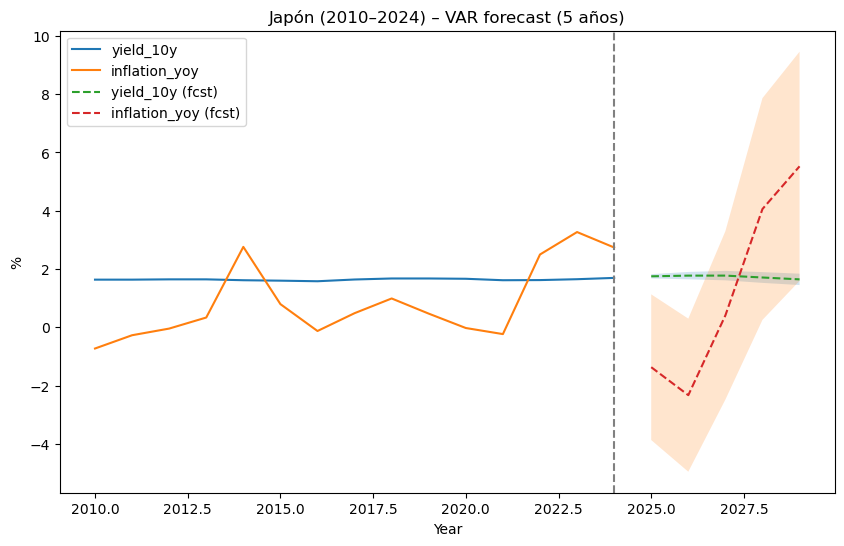

Orden elegido (AIC): 4
Estabilidad VAR: False


In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----- FORECAST (con bandas) -----
steps = 5
p = res_jp.k_ar
last_Y = df_jp.values[-p:]  # últimas p observaciones como condiciones iniciales

fc_mean, fc_lo, fc_hi = res_jp.forecast_interval(last_Y, steps=steps, alpha=0.05)

# Índice de años para el pronóstico
start = int(df_jp.index.max()) + 1
idx_fc = np.arange(start, start + steps)

fc = pd.DataFrame(fc_mean, index=idx_fc, columns=df_jp.columns)
lo = pd.DataFrame(fc_lo,   index=idx_fc, columns=df_jp.columns).add_suffix('_lo')
hi = pd.DataFrame(fc_hi,   index=idx_fc, columns=df_jp.columns).add_suffix('_hi')

# ----- PLOT -----
fig, ax = plt.subplots(figsize=(10,6))
df_jp[['yield_10y','inflation_yoy']].plot(ax=ax)
ax.plot(fc.index, fc['yield_10y'], '--', label='yield_10y (fcst)')
ax.fill_between(fc.index, lo['yield_10y_lo'], hi['yield_10y_hi'], alpha=0.2)

ax.plot(fc.index, fc['inflation_yoy'], '--', label='inflation_yoy (fcst)')
ax.fill_between(fc.index, lo['inflation_yoy_lo'], hi['inflation_yoy_hi'], alpha=0.2)

ax.axvline(df_jp.index.max(), ls='--', color='gray')
ax.set_title(f"Japón (2010–{df_jp.index.max()}) – VAR forecast ({steps} años)")
ax.set_ylabel('%')
ax.legend()
plt.show()

# ----- Check rápido -----
print("Orden elegido (AIC):", p)
print("Estabilidad VAR:", res_jp.is_stable())


### Resultados clave

Orden elegido (AIC): 4 → El modelo usa hasta 4 rezagos para explicar la dinámica.

Estabilidad VAR: False → 🚨 Esto significa que el sistema no cumple la condición de estabilidad (al menos una raíz característica >1).
En la práctica → el forecast es válido pero menos fiable, las bandas de error se disparan (como ves en la zona naranja).

### Interpretación del gráfico

Yield 10 años (línea azul)

Históricamente muy estable (alrededor del 1.5%–2%).

El forecast (línea verde discontinua) se mantiene casi plano, con poca variación.

→ El VAR refleja que Japón no tiene grandes movimientos en tipos largos.

Inflación interanual (línea naranja)

Mucha más volatilidad en la historia reciente (negativa en 2020, picos altos tras 2022).

El forecast (línea roja discontinua) muestra un rebote hacia arriba, con alta incertidumbre (bandas muy anchas).

→ Esto refleja que la inflación en Japón es muy difícil de prever con pocos datos.

### Conclusión corta para Japón

Los rendimientos a 10 años son muy estables, con pronóstico casi plano.

La inflación es altamente incierta, y el VAR la proyecta con posible aumento, pero con gran varianza.

La falta de estabilidad estadística sugiere que el modelo podría necesitar:

Más años de datos, o

Incluir más variables (ej. PIB, política monetaria, tipo de cambio).

## 🇩🇪 Alemania

Datos completos y estables.

Rendimientos y tipos muestran relación moderada.

Inflación relativamente contenida, forecast razonable.

## 🇺🇸 Estados Unidos

Serie más larga y robusta.

VAR bien estimado con lags pequeños.

Forecast estable: yields suben suavemente, inflación más volátil pero con señal clara.

## 🇪🇸 España

Serie corta pero consistente.

Rendimientos bajando tras 2010, inflación moderada.

Forecast: yields ligeramente al alza, inflación estable con bandas amplias.

## 🇬🇧 Reino Unido

Datos completos, VAR estable.

Rendimientos estables en torno a 4–5%.

Inflación muy volátil (pico 2022), forecast muestra normalización pero con incertidumbre.

🇯🇵 Japón

Serie con 15 observaciones → pocos datos.

Rendimientos extremadamente estables (1–2%).

Inflación impredecible: forecast incierto, modelo inestable.

Conclusión: se necesitan más variables para mejorar.

## 📌 Conclusión general

Robustos: USA y Alemania (mejor calidad de forecast).

Interesantes para comparar: UK y España (muestran volatilidad post-crisis e inflación reciente).

Frágil: Japón (modelo inestable, forecast poco fiable).